In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from utils import plot_correlation, plot_boxplots, plot_zeros, plot_boxplot, get_seasonality_trend_overview, plot_period_mean, plot_periodogram
import warnings
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import MinMaxScaler

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

In [2]:
# Import
df_train = pd.read_csv('originalni_datasetovi/train.csv')
df_test = pd.read_csv('originalni_datasetovi/test.csv')
df_stores = pd.read_csv('originalni_datasetovi/stores.csv')
df_oil = pd.read_csv('originalni_datasetovi/oil.csv')
df_holidays = pd.read_csv('originalni_datasetovi/holidays_events.csv')
df_transactions = pd.read_csv('originalni_datasetovi/transactions.csv').sort_values(['store_nbr', 'date'])

# Vizuelization

## Oil
Oil data contains only two attributes: **Date** and **dcoilwtico**(oil price for a given day).

In [3]:
df_oil.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [4]:
df_oil.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True) # change column name for readability
df_oil['date'] = pd.to_datetime(df_oil.date)
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1218 non-null   datetime64[ns]
 1   oil_price  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


There are no data about oil prices on weekends so we use linear interpolation for those dates. \
Linear interpolation ignores the index and treat the values as equally spaced.

In [5]:
df_oil.loc[df_oil['date'] == '2013-01-01', 'oil_price'] = 93.14 # since linear interpolation doesnt work on data thats not between data points we use 2nd data point as 1st data point
df_oil = df_oil.interpolate(method='linear', limit=20)
df_oil.describe()

date    oil_price
count                 1218  1218.000000
mean   2015-05-02 12:00:00    67.682742
min    2013-01-01 00:00:00    26.190000
25%    2014-03-03 06:00:00    46.422500
50%    2015-05-02 12:00:00    53.185000
75%    2016-06-30 18:00:00    95.685000
max    2017-08-31 00:00:00   110.620000
std                    NaN    25.632933

We see 2 peaks on distribution plot, one for data before 2015 and one for data after 2015.

Text(0.5, 1.0, 'Distribution : Oil Price')

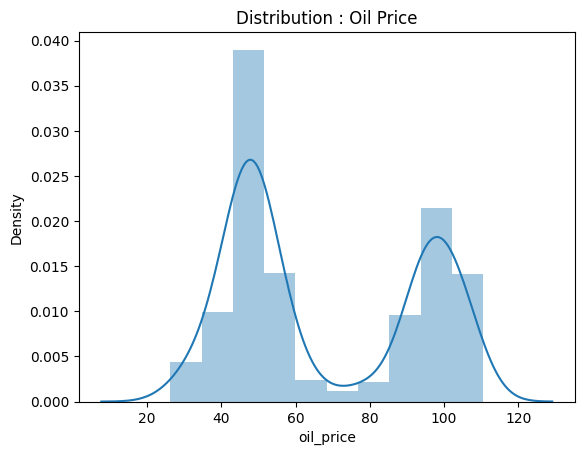

In [6]:
sns.distplot(df_oil['oil_price'])
plt.title('Distribution : Oil Price')

Text(0, 0.5, 'Oil Price')

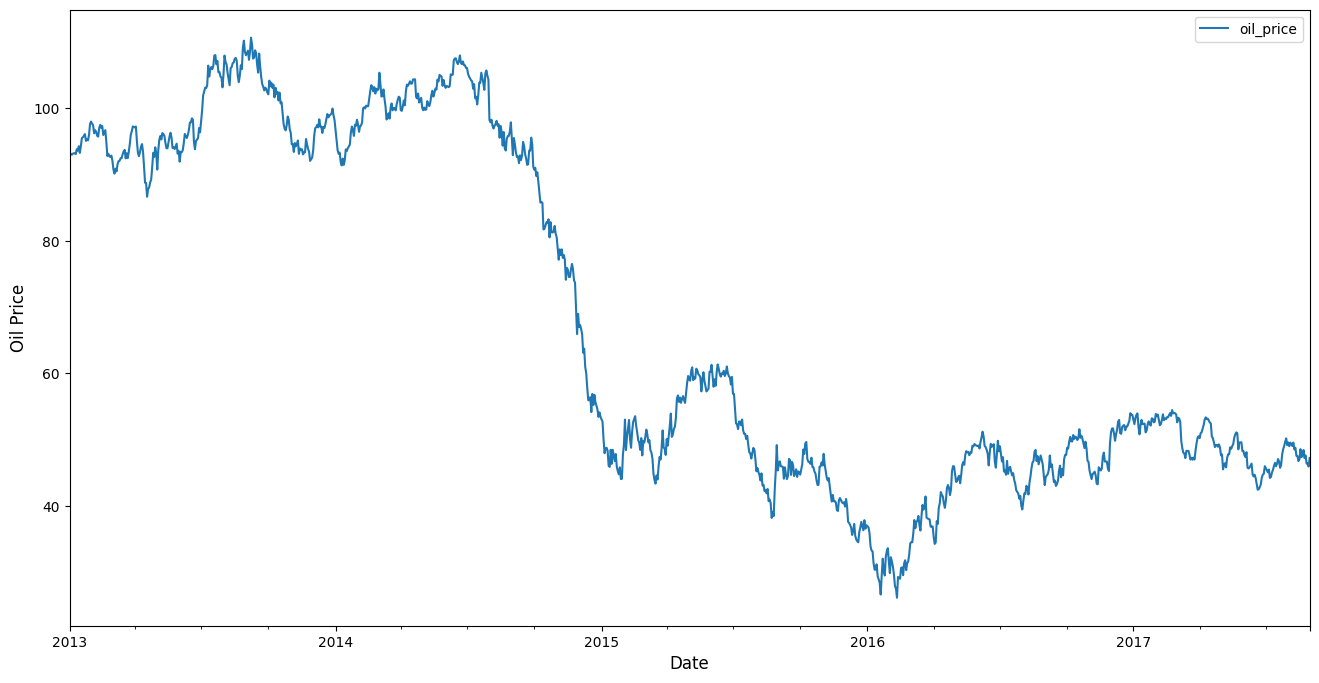

In [7]:
ax = df_oil.set_index('date').plot(figsize = (16, 8))
ax.set_xlabel('Date', fontsize = 'large')
ax.set_ylabel('Oil Price', fontsize = 'large')

Dip in mid-2014 to early 2015 was primarily driven by supply factors, including booming U.S. oil production, receding geopolitical concerns, and shifting OPEC policies. \
In November 2014, OPEC announced a new strategy geared towards improving its market share. Oil-market analysts interpreted this as an attempt to squeeze higher-cost \
producers including US shale oil out of the market. Over the next year, crude oil prices crashed, with large repercussions for the global economy.

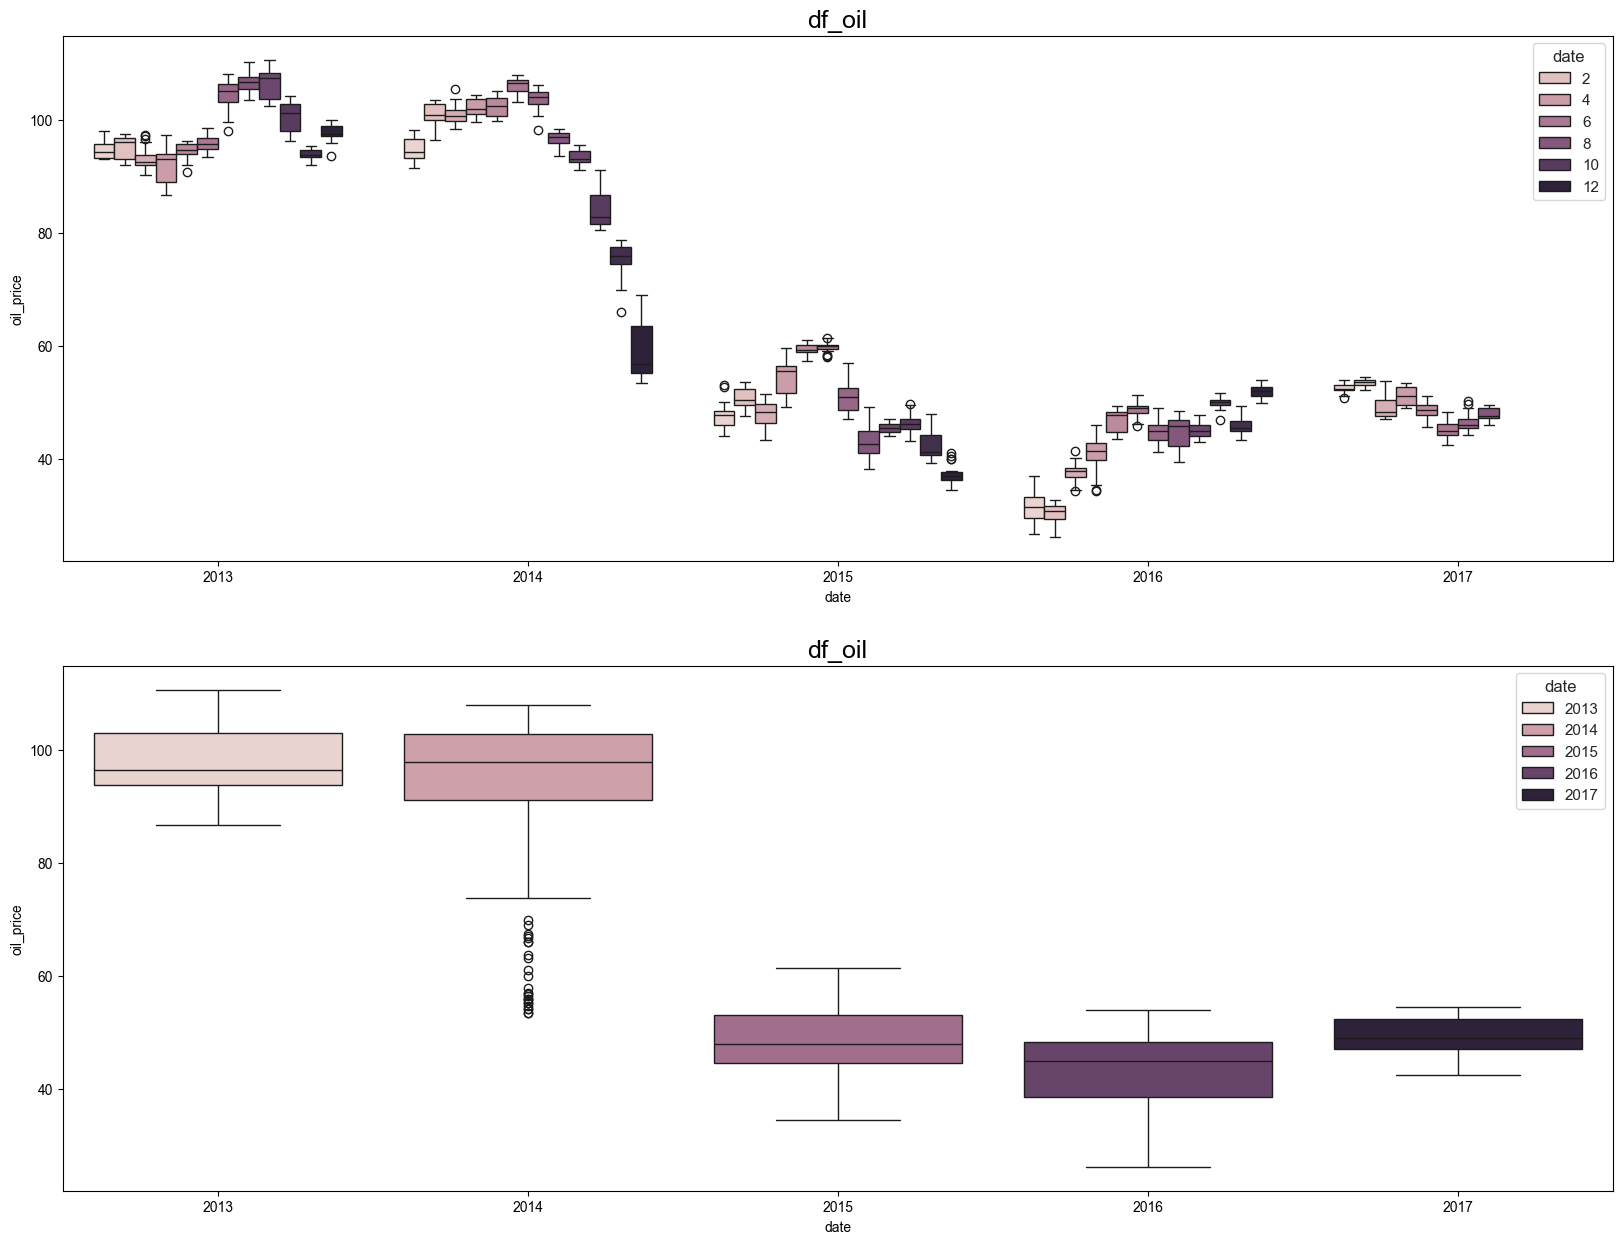

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
plot_boxplot('pastel', df_oil['date'].dt.year, df_oil['oil_price'], df_oil['date'].dt.month, axes[0], 'df_oil')
plot_boxplot('pastel', df_oil['date'].dt.year, df_oil['oil_price'], df_oil['date'].dt.year, axes[1], 'df_oil')

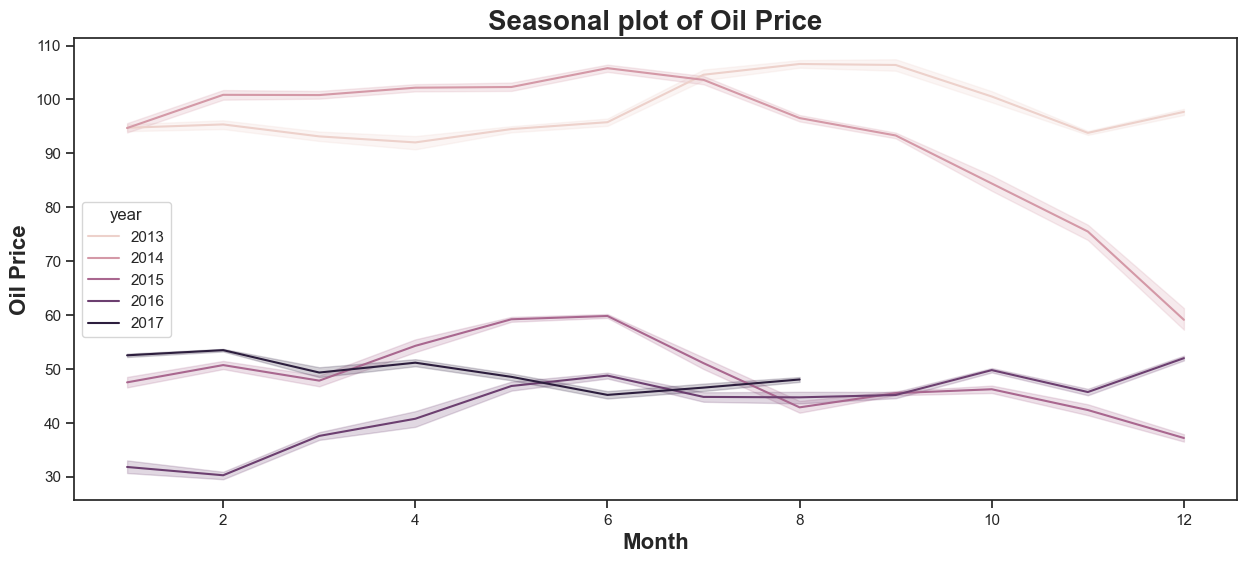

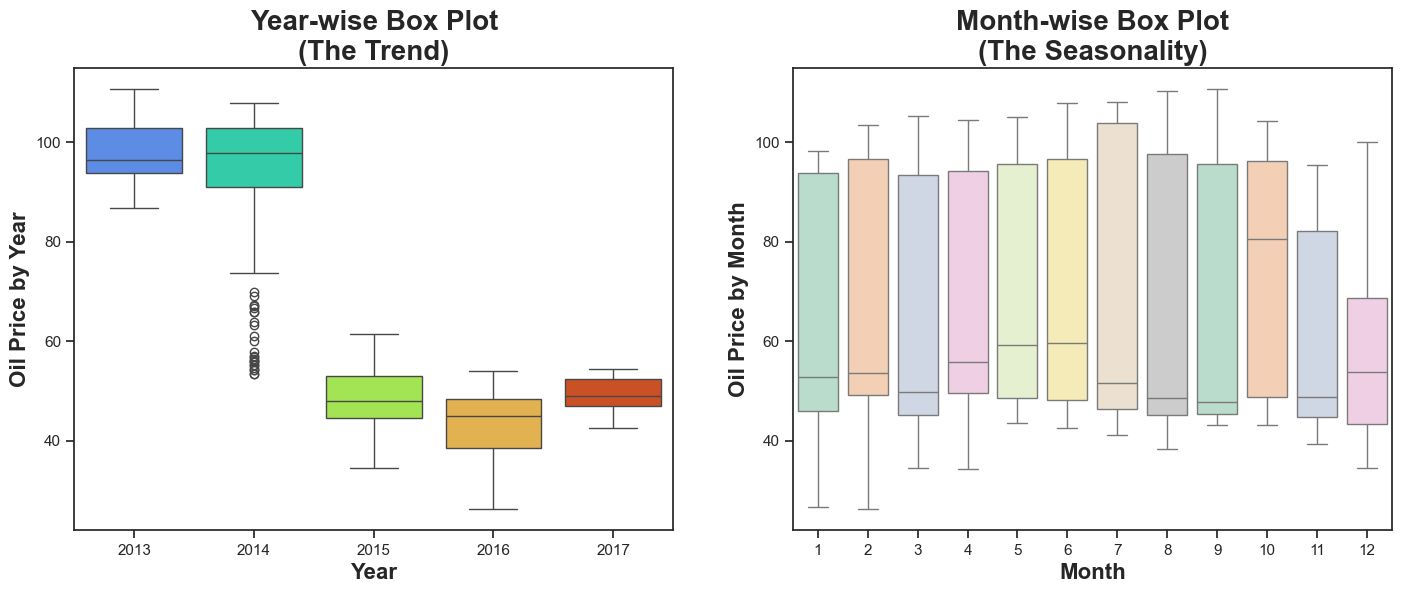

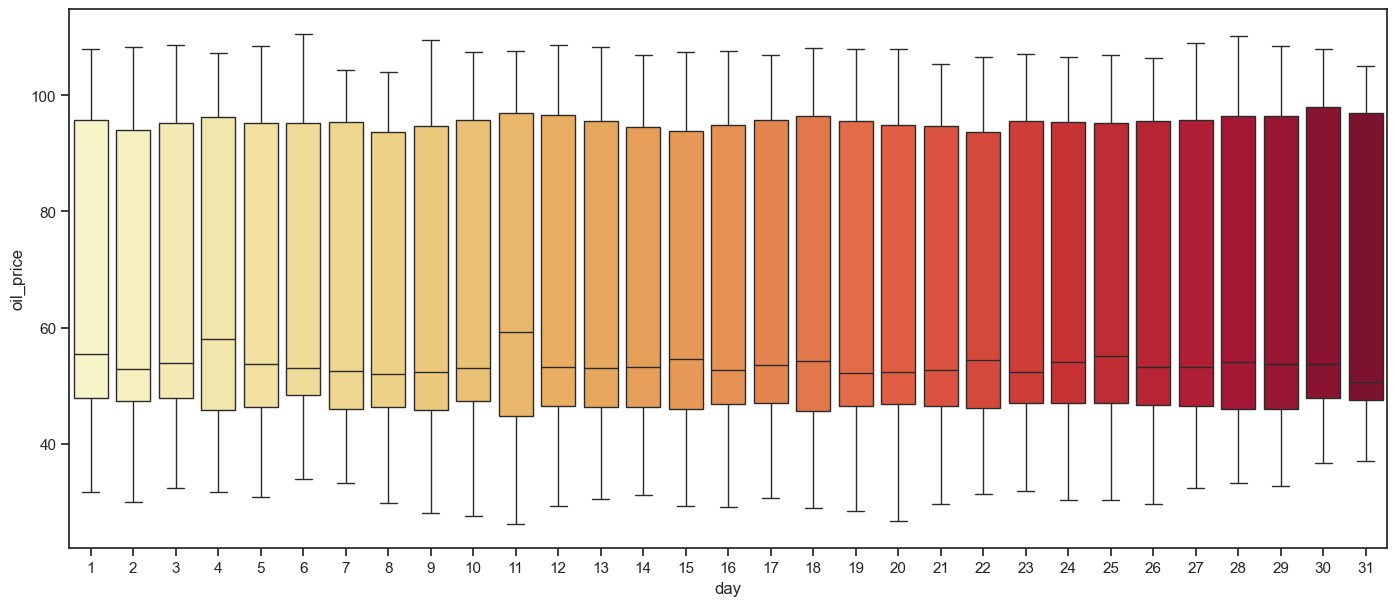

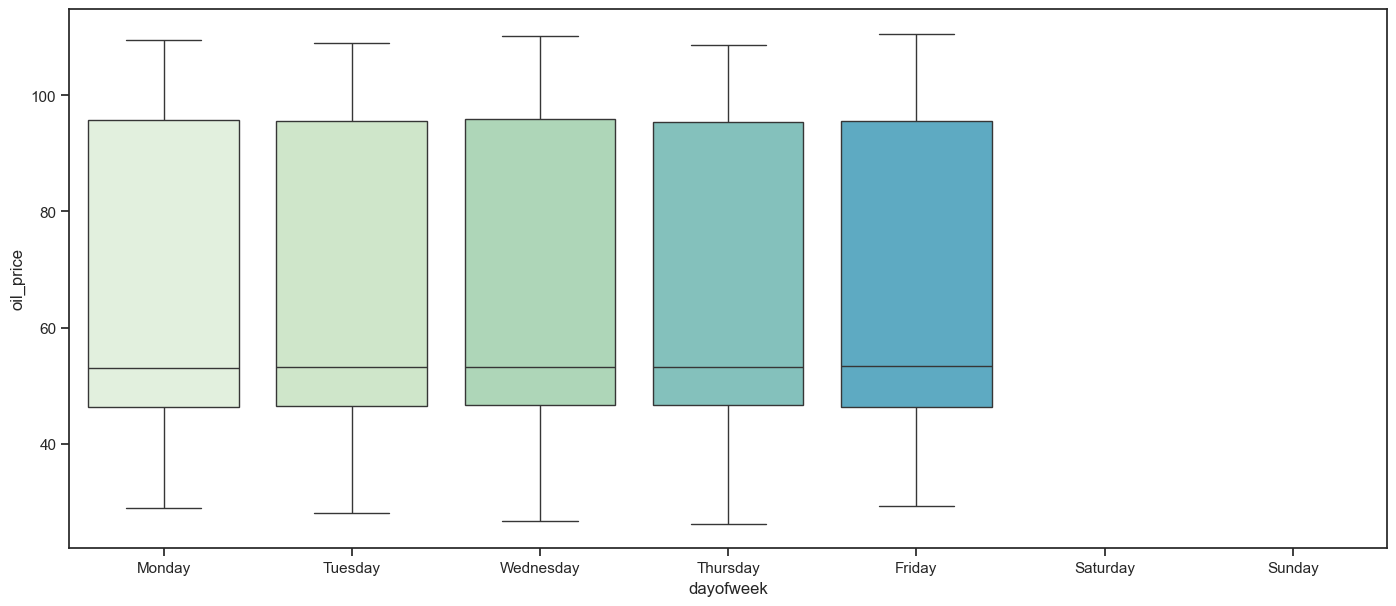

In [9]:
get_seasonality_trend_overview(df_oil, 'oil_price', title_name='Oil Price')

## Transactions
Transaction data contains 3 attributes: **date**, **store_nbr** (store number where transactions took place) and **transactions** (number of transactions on a given date in a specified store).

In [10]:
df_transactions.head()

date  store_nbr  transactions
1    2013-01-02          1          2111
47   2013-01-03          1          1833
93   2013-01-04          1          1863
139  2013-01-05          1          1509
185  2013-01-06          1           520

In [11]:
df_transactions['date'] = pd.to_datetime(df_transactions.date)
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83488 entries, 1 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.5 MB


Text(0.5, 1.0, 'Distribution : Transactions')

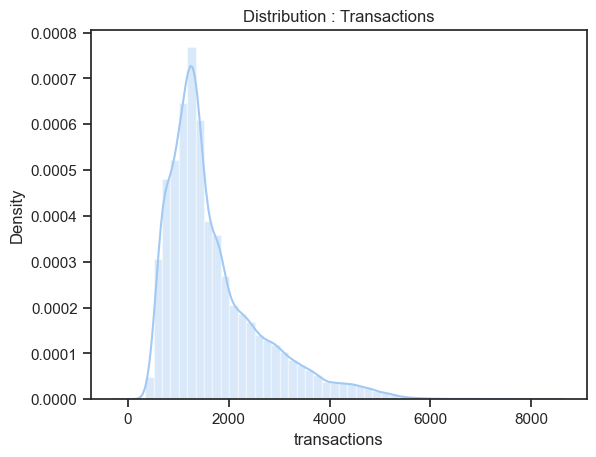

In [12]:
sns.distplot(df_transactions['transactions'])
plt.title('Distribution : Transactions')

       transactions
month              
1          12156198
2          11707934
3          12917913
4          12633531
5          13112679
6          12482179
7          12827206
8          11545571
9           9811819
10         10048234
11          9877873
12         12357808
      transactions
year              
2013      29107173
2014      30006929
2015      31312370
2016      31052337
2017      20000136
            transactions
year month              
2013 1           2289558
     2           2169615
     3           2458683
     4           2344905
     5           2467465
     6           2392206
     7           2401968
     8           2461139
     9           2380462
     10          2408440
     11          2369866
     12          2962866
2014 1           2393528
     2           2278167
     3           2545427
     4           2455666
     5           2503262
     6           2399144
     7           2442341
     8           2537572
     9           2449131
     10     

Text(0, 0.5, 'Transactions')

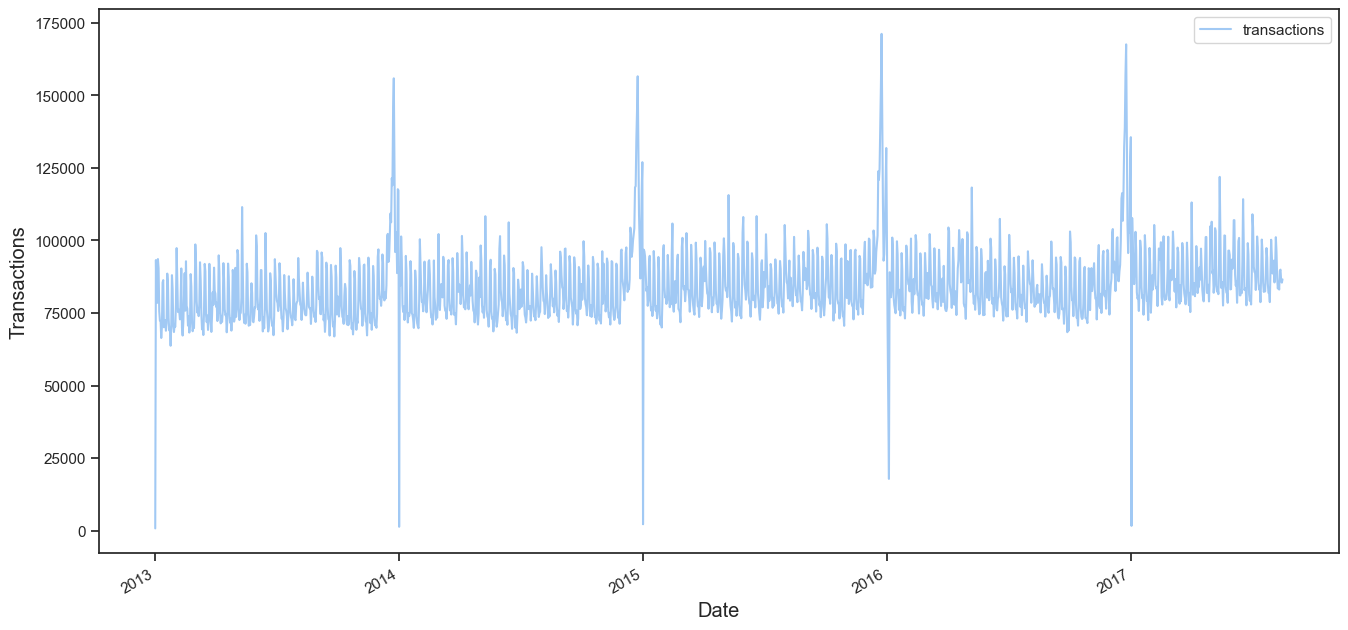

In [13]:
ax = df_transactions.groupby(['date'])[['transactions']].sum().plot(figsize = (16, 8))
df_transactions_copy = df_transactions.copy()
df_transactions_copy['year'] = df_transactions.date.dt.year
df_transactions_copy['month'] = df_transactions.date.dt.month
print(df_transactions_copy.groupby(['month'])[['transactions']].sum())
print(df_transactions_copy.groupby(['year'])[['transactions']].sum())
print(df_transactions_copy.groupby(['year', 'month'])[['transactions']].sum())
ax.set_xlabel('Date', fontsize = 'large')
ax.set_ylabel('Transactions', fontsize = 'large')

Every year transactions peak in December

Spearman Correlation between Total Sales and Transactions: 0.8175


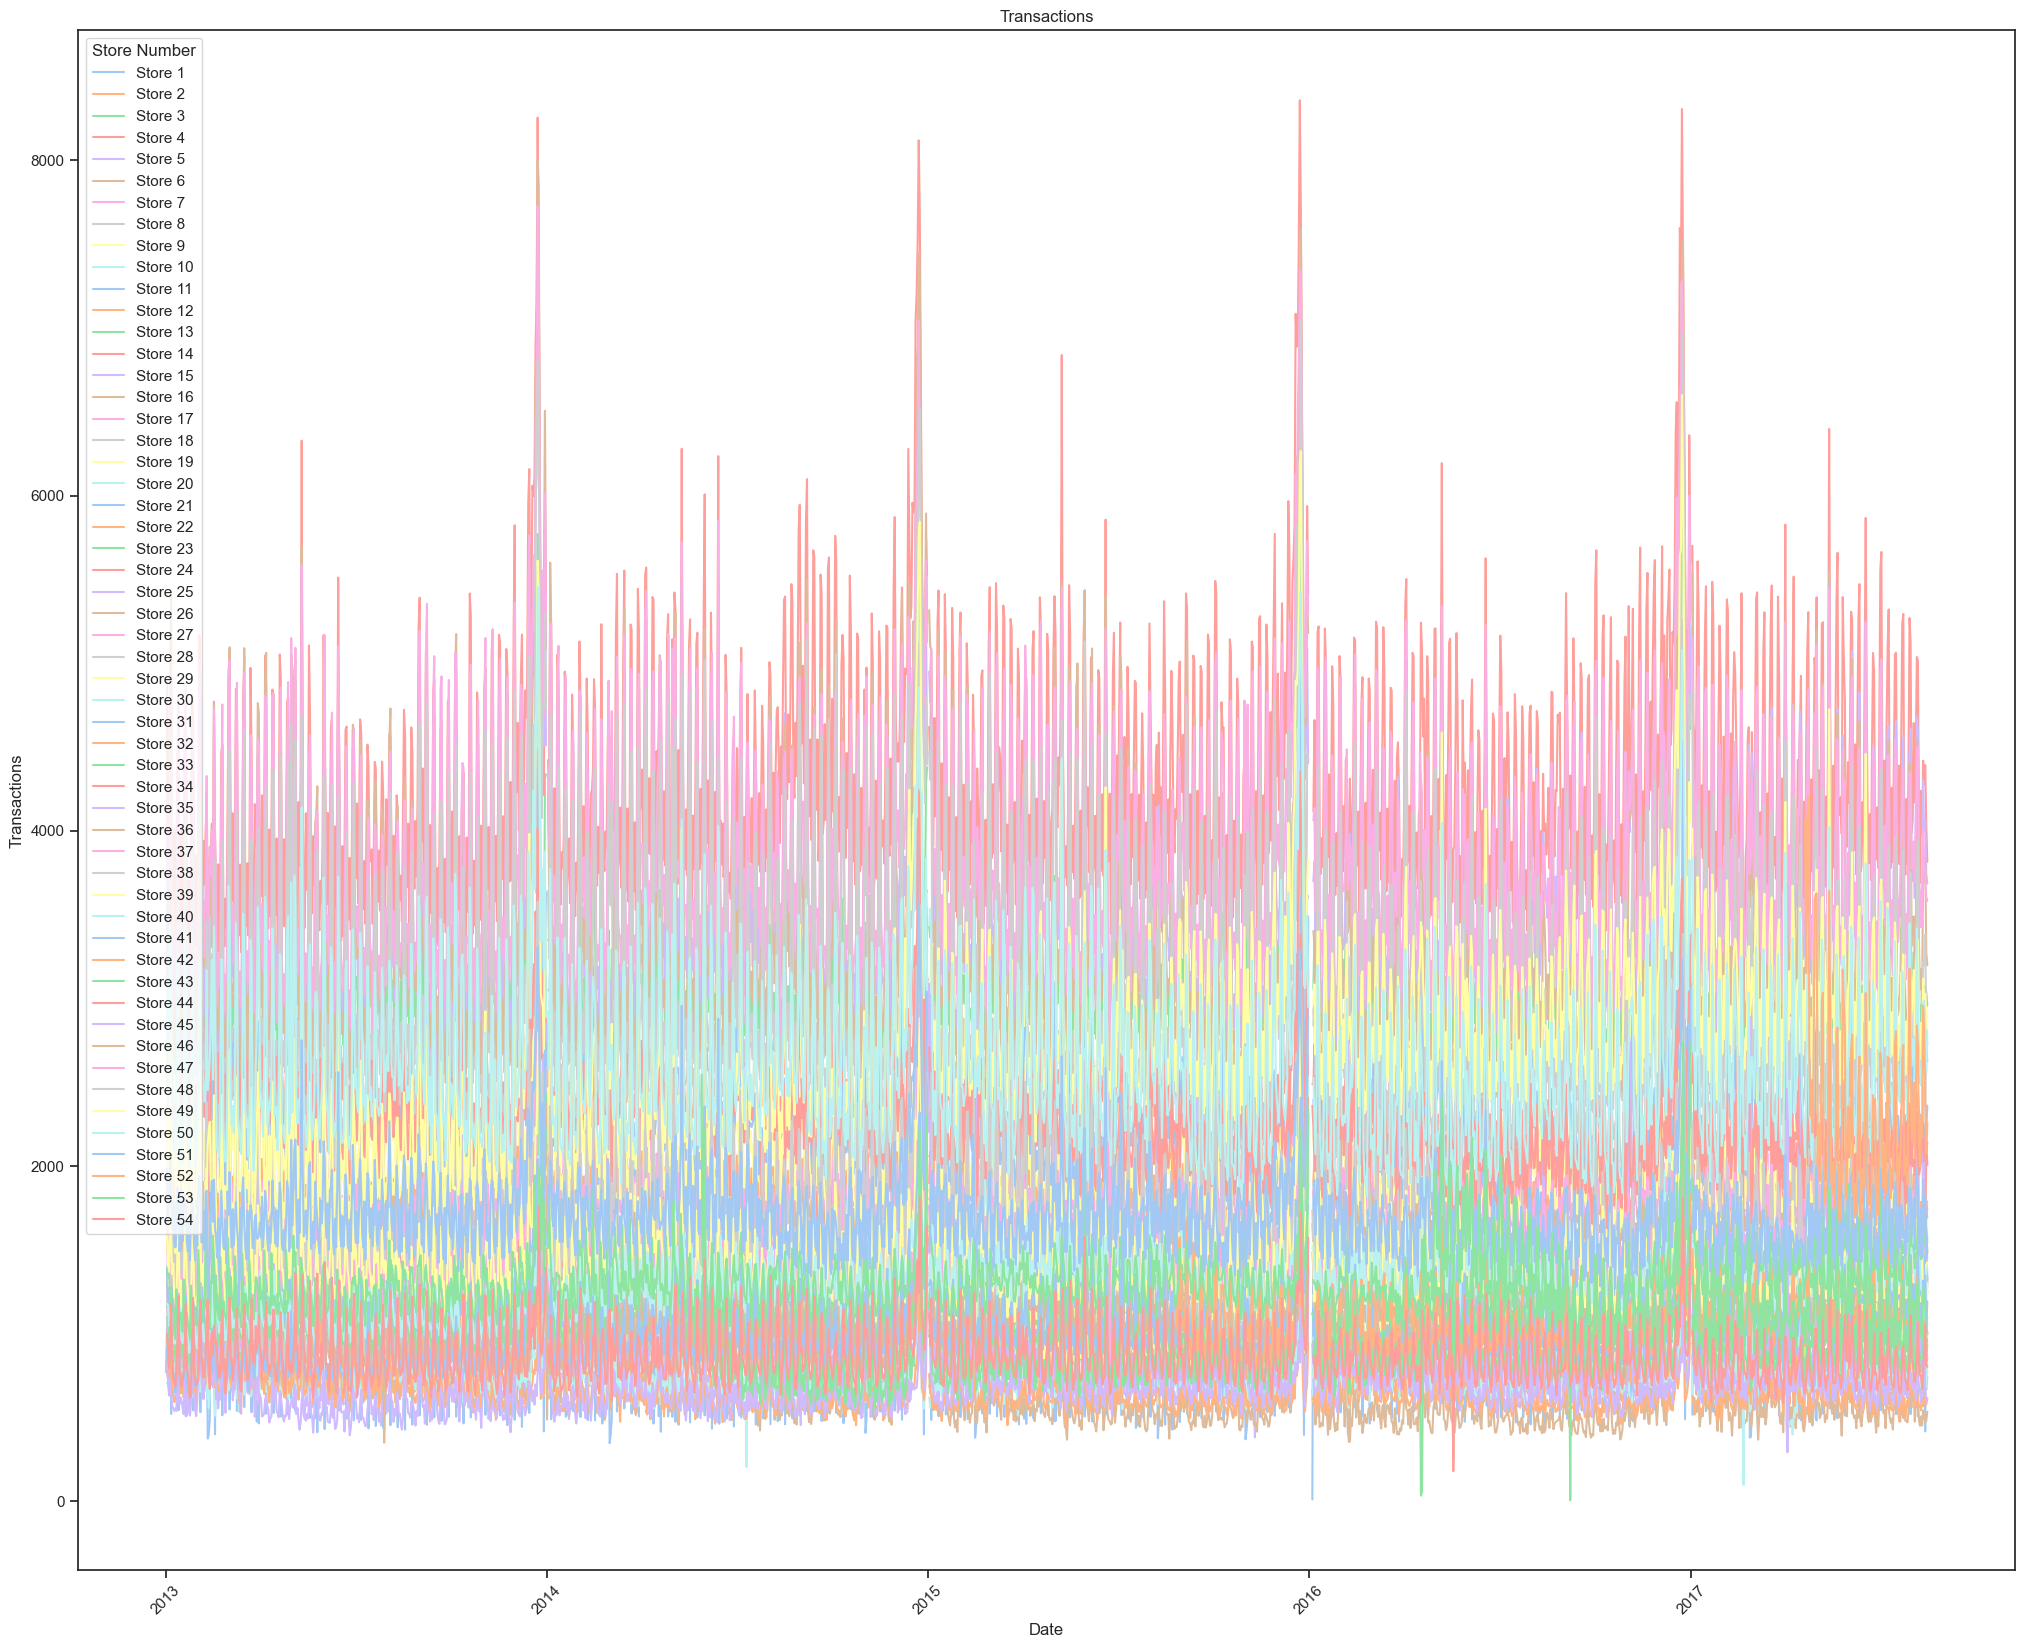

In [14]:
df_train['date'] = pd.to_datetime(df_train.date)

# merge train data and transactions data to check transaction/sales correlation
temp = pd.merge(df_train.groupby(['date', 'store_nbr']).sales.sum().reset_index(), df_transactions, how = 'left')
print('Spearman Correlation between Total Sales and Transactions: {:,.4f}'.format(temp.corr('spearman').sales.loc['transactions']))

transactions_sorted = temp.sort_values(['store_nbr', 'date'])

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(25, 20))

# Plot each store's transactions
for store_nbr, data in transactions_sorted.groupby('store_nbr'):
    ax.plot(data['date'], data['transactions'], label=f'Store {store_nbr}')

# Set the title and labels
ax.set_title('Transactions')
ax.set_xlabel('Date')
ax.set_ylabel('Transactions')
ax.legend(title='Store Number')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()

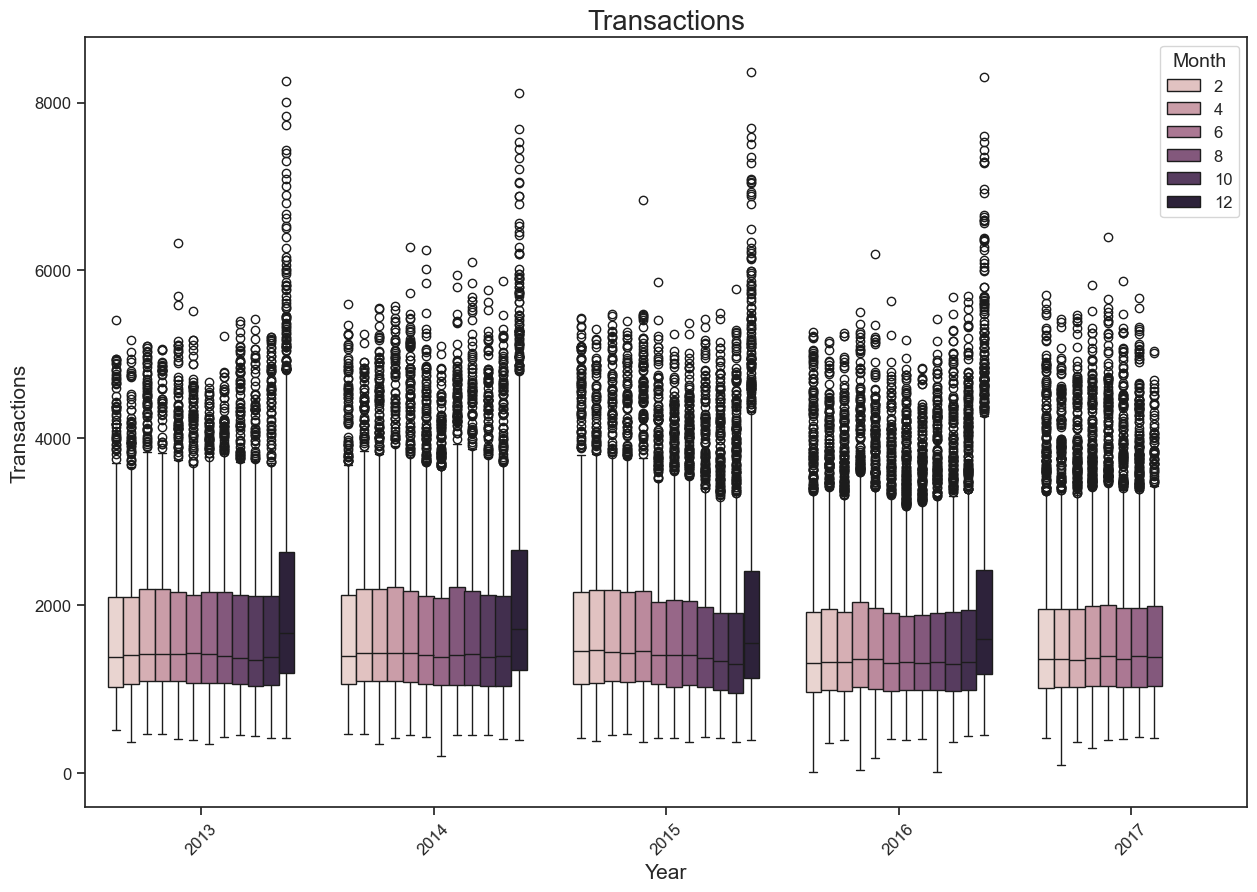

In [15]:
temp = df_transactions.copy()
temp['year'] = temp.date.dt.year
temp['month'] = temp.date.dt.month
plt.figure(figsize=(15, 10))

# Create a boxplot with Seaborn
sns.boxplot(data=temp, x='year', y='transactions', hue='month')

# Set the title and labels
plt.title('Transactions', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Transactions', fontsize=15)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='Month', fontsize=12, title_fontsize=14)
plt.show()

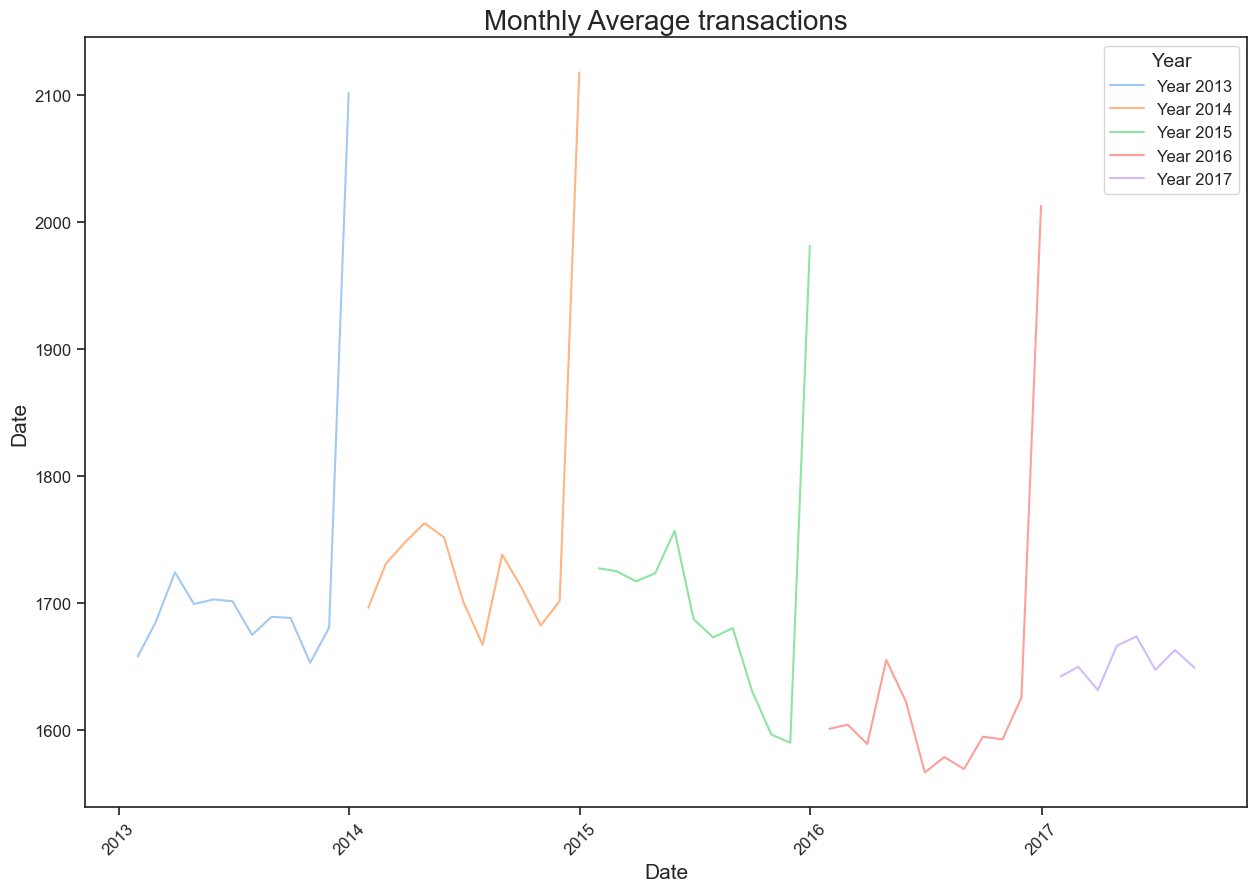

In [16]:
plot_period_mean(df_transactions, 'transactions', period='M')

plot_period_mean(df_transactions, 'transactions', period='DW')

Highest number of transactions are during weekends with a peak on Saturday

## Stores
Stores data contains 5 attributes: **store_nbr**, **city**, **state**, **type**, **cluster**.

In [17]:
df_stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [18]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [19]:
df_stores['city'].value_counts()

city
Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: count, dtype: int64

In [20]:
df_stores['type'].value_counts()

type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

## Holidays
Holidays data contains 6 attributes: **date**, **type**, **locale**, **locale_name**, **description**, **transferred**.

In [21]:
df_holidays.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [22]:
df_holidays['date'] = pd.to_datetime(df_holidays.date)
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [23]:
df_holidays.describe(include='O')

type    locale locale_name description
count       350       350         350         350
unique        6         3          24         103
top     Holiday  National     Ecuador    Carnaval
freq        221       174         174          10

In [24]:
set(df_holidays.type.to_list())

{'Additional', 'Bridge', 'Event', 'Holiday', 'Transfer', 'Work Day'}

In [25]:
set(df_holidays.locale.to_list())

{'Local', 'National', 'Regional'}

<Axes: title={'center': 'Counts of type of holiday'}, xlabel='locale', ylabel='count'>

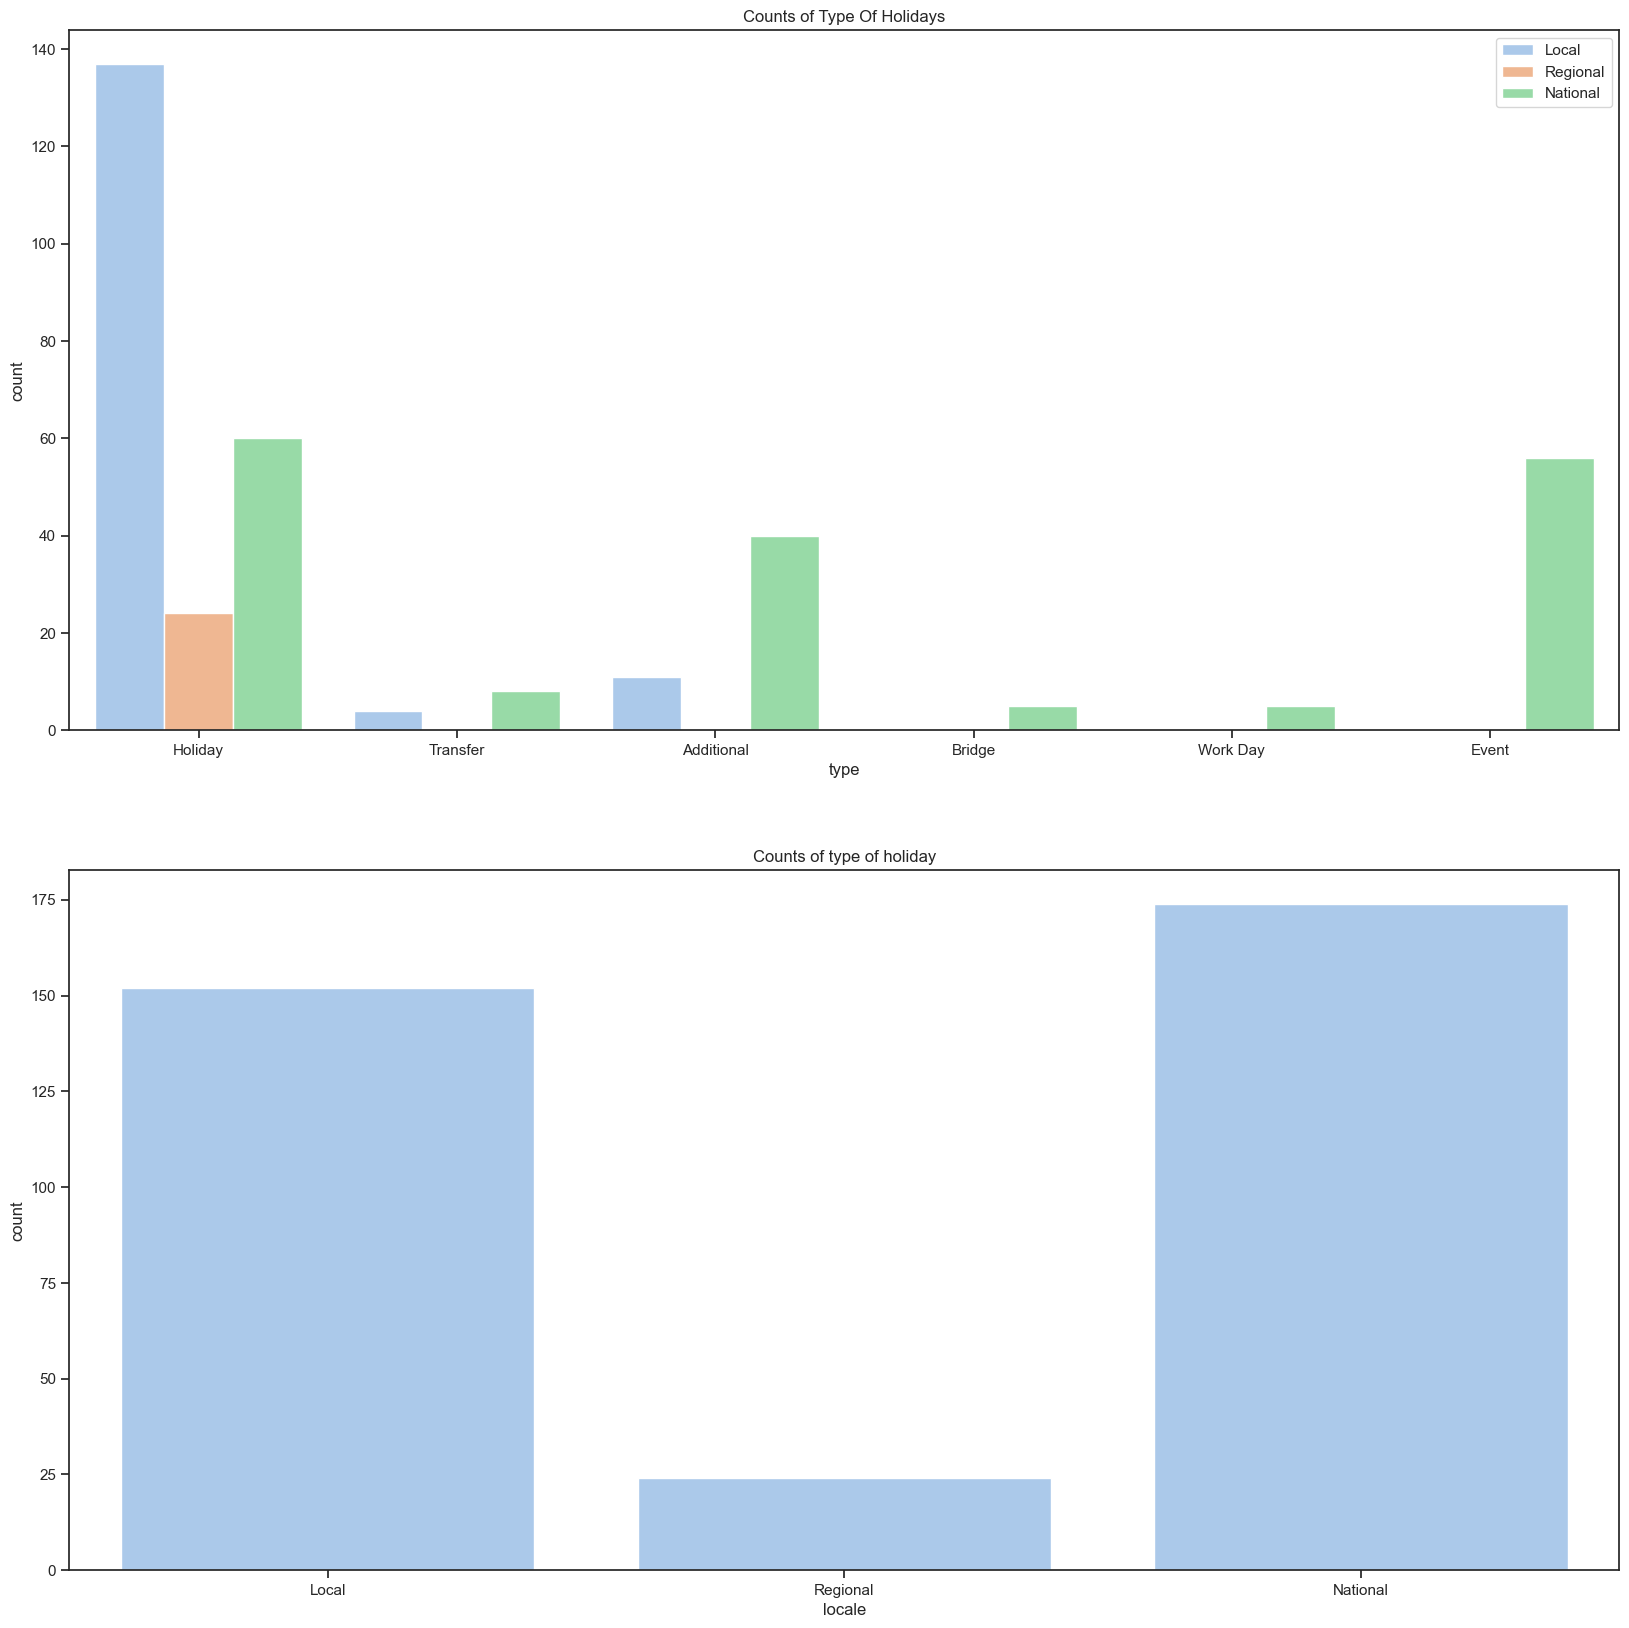

In [26]:
plt.subplots(1,2,figsize=(20,20))
plt.subplot(211)
plt.title('Counts of Type Of Holidays')
sns.countplot(x=df_holidays.type, hue=df_holidays.locale)
plt.legend(loc='upper right')
plt.subplot(212)
plt.title('Counts of type of holiday')
sns.countplot(x=df_holidays.locale)

## Train Data
Train data contains 6 attributes: **id**, **date**, **store_nbr**, **family**, **sales**, **onpromotion**.

In [27]:
df_train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

In [28]:
df_train['date'] = pd.to_datetime(df_train.date)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [29]:
df_train.describe()

id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703088384  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.502218e+05            2014-02-26 18:00:00  1.400000e+01   
50%    1.500444e+06            2015-04-24 12:00:00  2.750000e+01   
75%    2.250665e+06            2016-06-19 06:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000e+01   
std    8.662819e+05                            NaN  1.558579e+01   

              sales   onpromotion  
count  3.000888e+06  3.000888e+06  
mean   3.577757e+02  2.602770e+00  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    1.100000e+01  0.000000e+00  
75%    1.958473e+02  0.000000e+00  
max    1.247170e+05  7.410000e+02  
std    1.101998e+03  1.221888e+01

In [30]:
print(set(df_train.family.to_list()))
len(set(df_train.family.to_list()))

{'DAIRY', 'HOME CARE', 'BEVERAGES', 'POULTRY', 'GROCERY I', 'PRODUCE', 'PET SUPPLIES', 'AUTOMOTIVE', 'HOME AND KITCHEN I', 'LAWN AND GARDEN', 'BABY CARE', 'MEATS', 'FROZEN FOODS', 'EGGS', 'CELEBRATION', 'CLEANING', 'SCHOOL AND OFFICE SUPPLIES', 'MAGAZINES', 'LINGERIE', 'BOOKS', 'LADIESWEAR', 'BREAD/BAKERY', 'PLAYERS AND ELECTRONICS', 'LIQUOR,WINE,BEER', 'PERSONAL CARE', 'BEAUTY', 'DELI', 'HOME APPLIANCES', 'HOME AND KITCHEN II', 'HARDWARE', 'PREPARED FOODS', 'SEAFOOD', 'GROCERY II'}


33

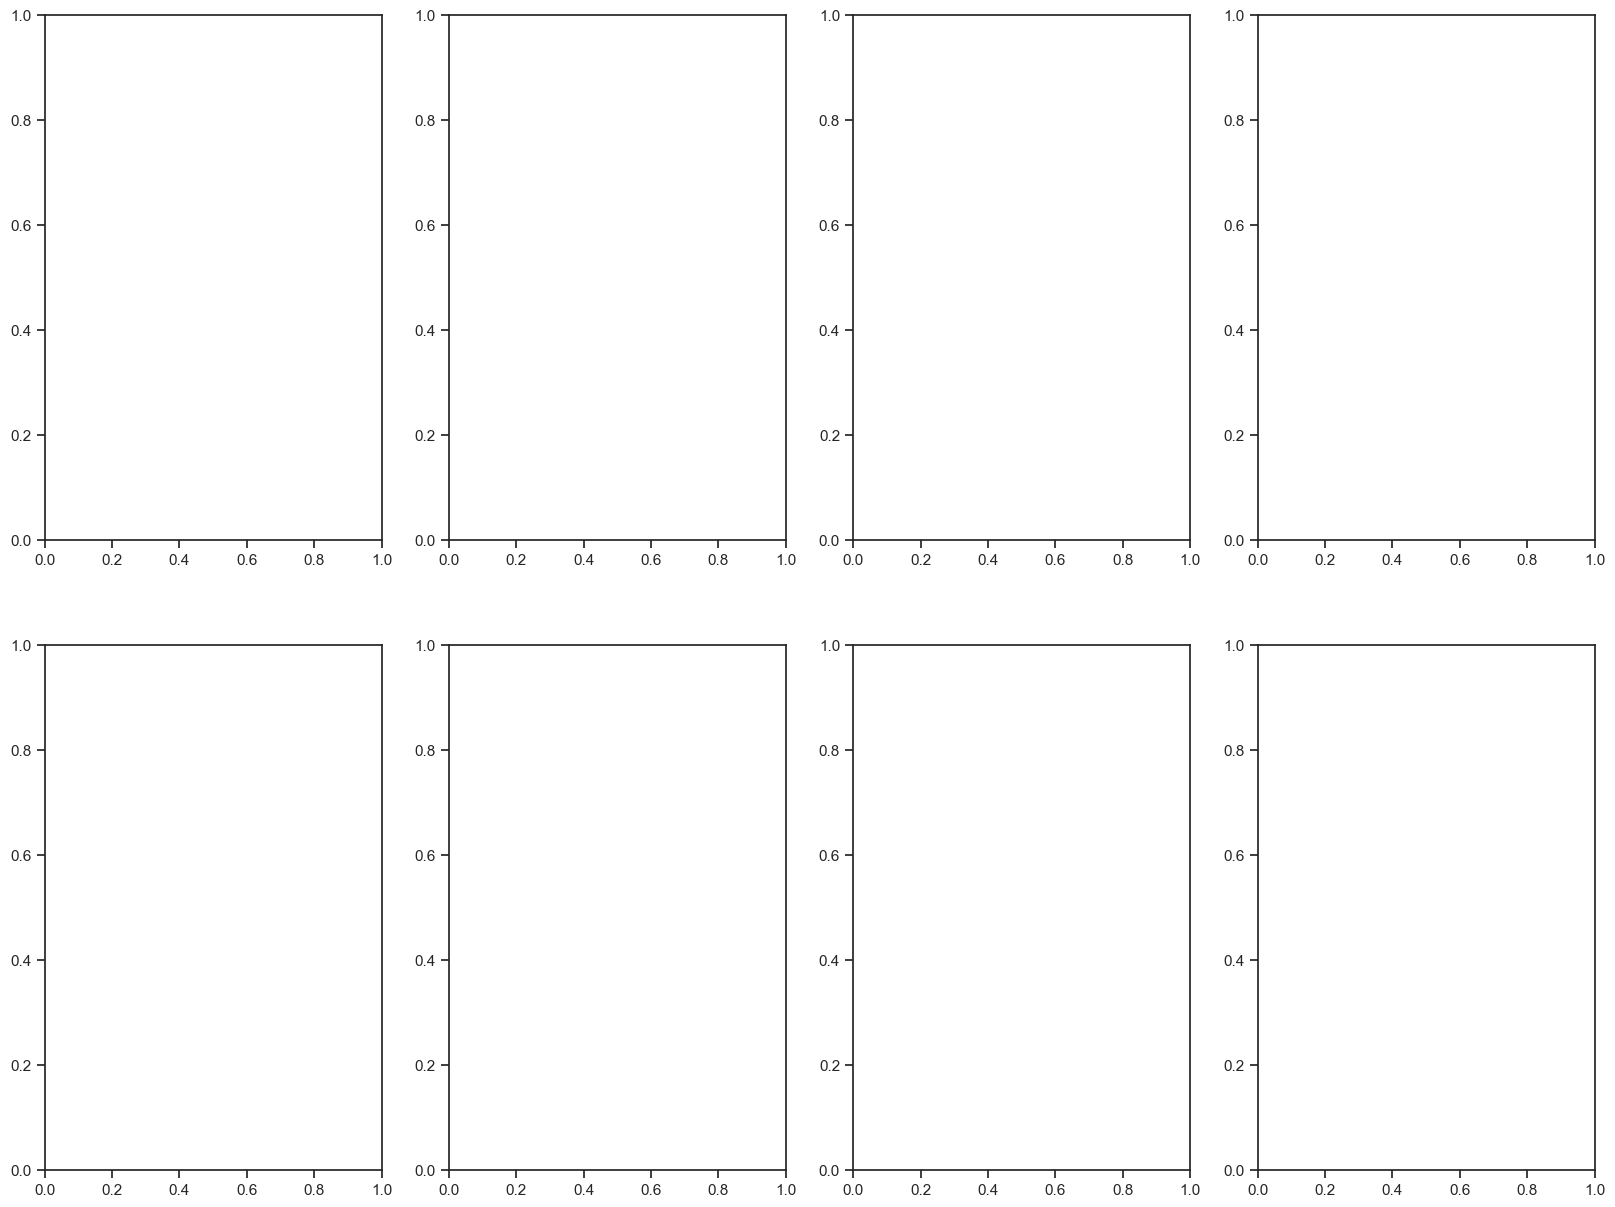

In [31]:
oil = df_oil.copy()

# Resample -> index is now date and if there is entry missing for some date it will be 0 for oil_prices
oil = oil.set_index('date').oil_price.resample('D').sum().reset_index()

# Interpolate
oil['oil_price'] = np.where(oil['oil_price'] == 0, np.nan, oil['oil_price'])
oil['oil_price'] = oil.oil_price.interpolate()

# merge train data and oil data
a = pd.merge(df_train.groupby(['date', 'family']).sales.sum().reset_index(), oil.drop('oil_price', axis = 1), how = 'left')
c = a.groupby('family').corr('spearman').reset_index()
c = c[c.level_1 == 'oil_price'][['family', 'sales']].sort_values('sales')

# extract only statisticaly significant correlations
df_significant_corelation = c[(c['sales'] >= 0.6) | (c['sales'] <= -0.6)]
df_significant_corelation

# we make 2x4 matrix of plots
fig, axes = plt.subplots(2, 4, figsize=(20, 15))
for i, family in enumerate(df_significant_corelation.family):
    if i < 4:
         a[a.family == family].plot.scatter(x = 'oil_price', y = 'sales', ax=axes[0, i-1])
         axes[0, i-1].set_title(family+'\n Correlation:'+str(df_significant_corelation[df_significant_corelation.family == family].sales.iloc[0])[:6], fontsize = 12)
         axes[0, i-1].axvline(x=70, color='r', linestyle='--')
    else:
         a[a.family == family].plot.scatter(x = 'oil_price', y = 'sales', ax=axes[1, i-6])
         axes[1, i-6].set_title(family+'\n Correlation:'+str(df_significant_corelation[df_significant_corelation.family == family].sales.iloc[0])[:6], fontsize = 12)
         axes[1, i-6].axvline(x=70, color='r', linestyle='--')

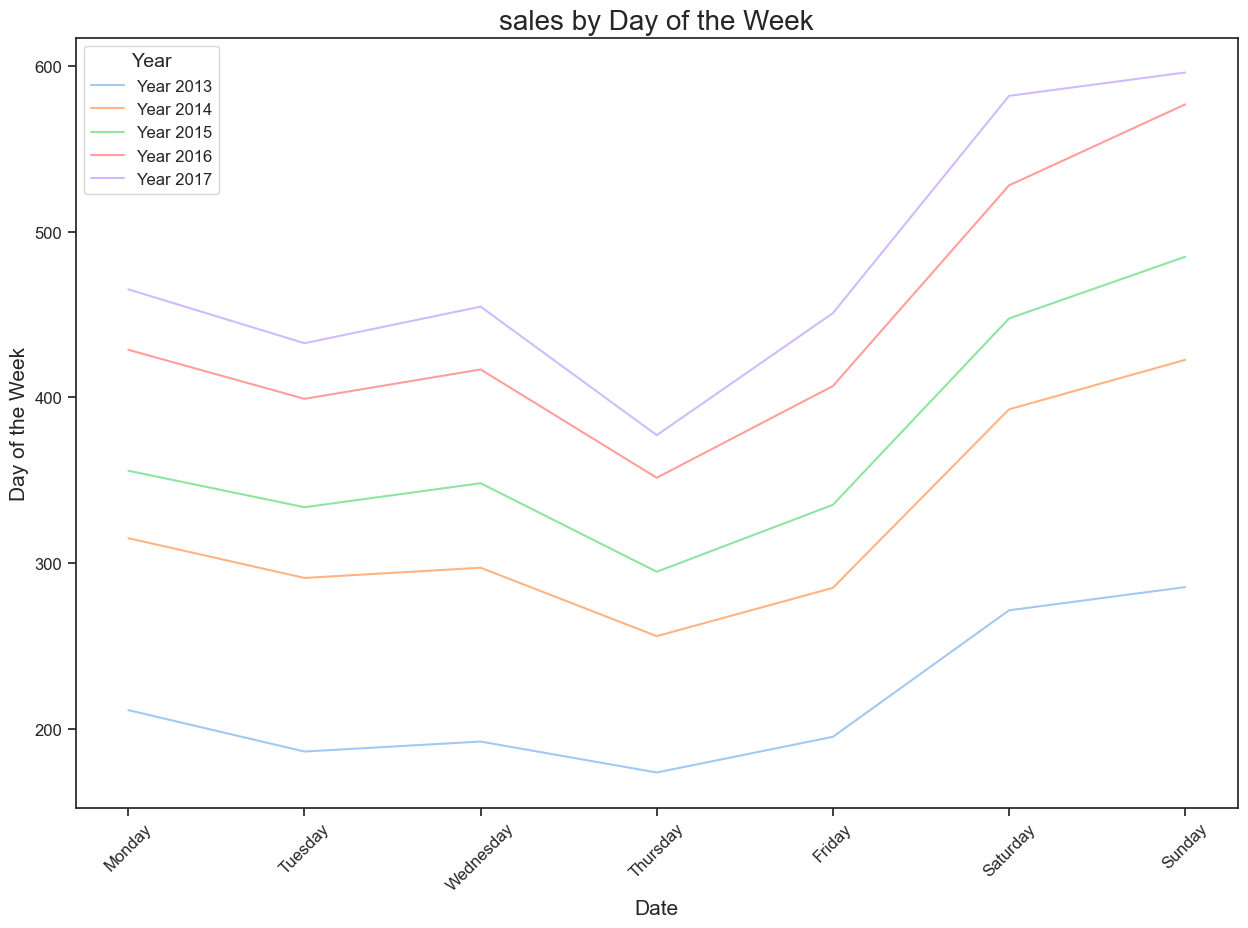

In [32]:
plot_period_mean(df_train, 'sales', period='DW')

Peaks are during weekends

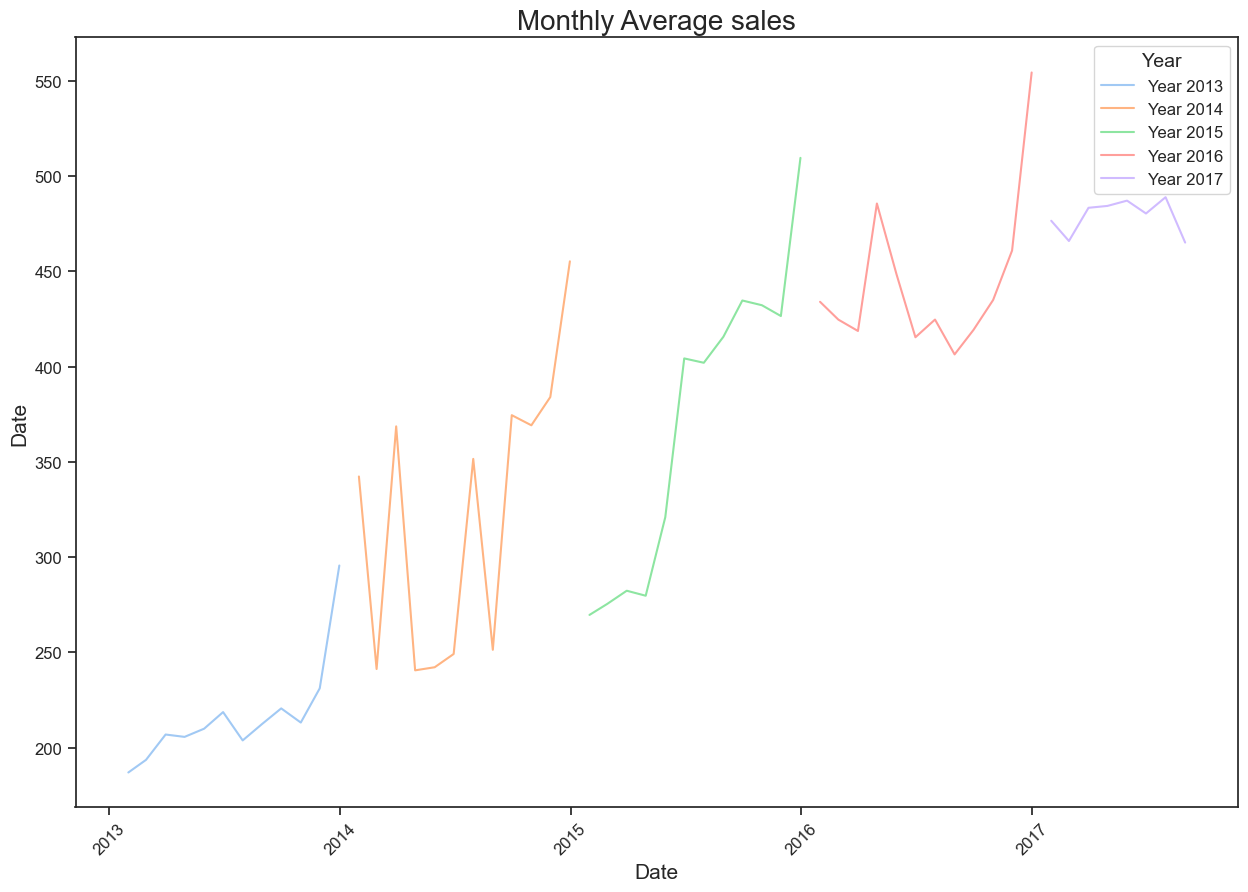

In [33]:
plot_period_mean(df_train, 'sales', period='M')

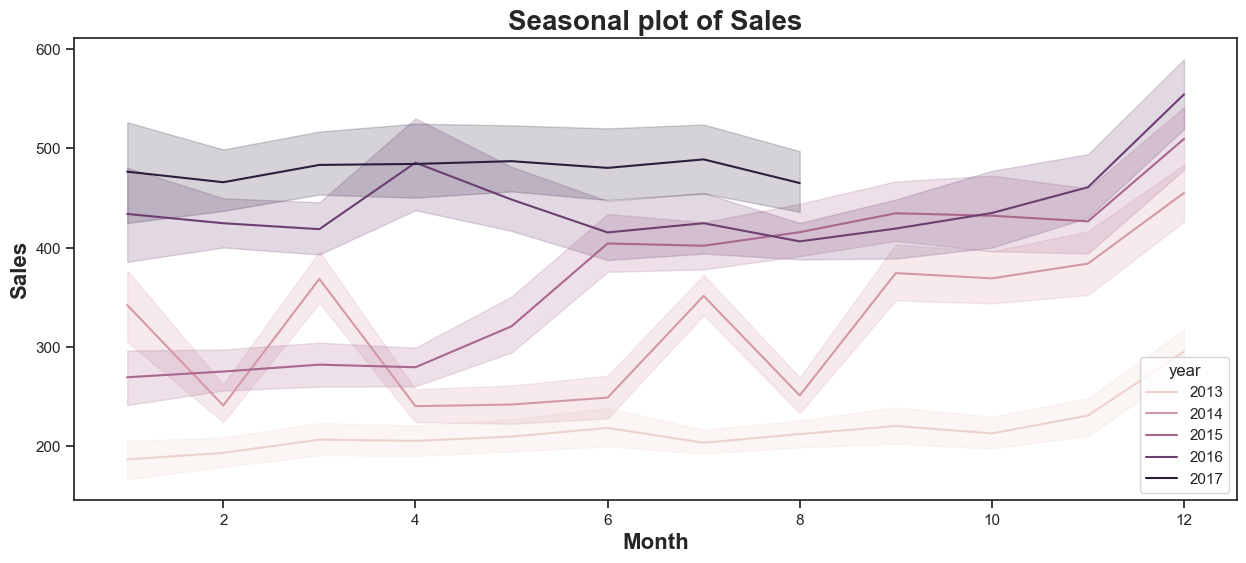

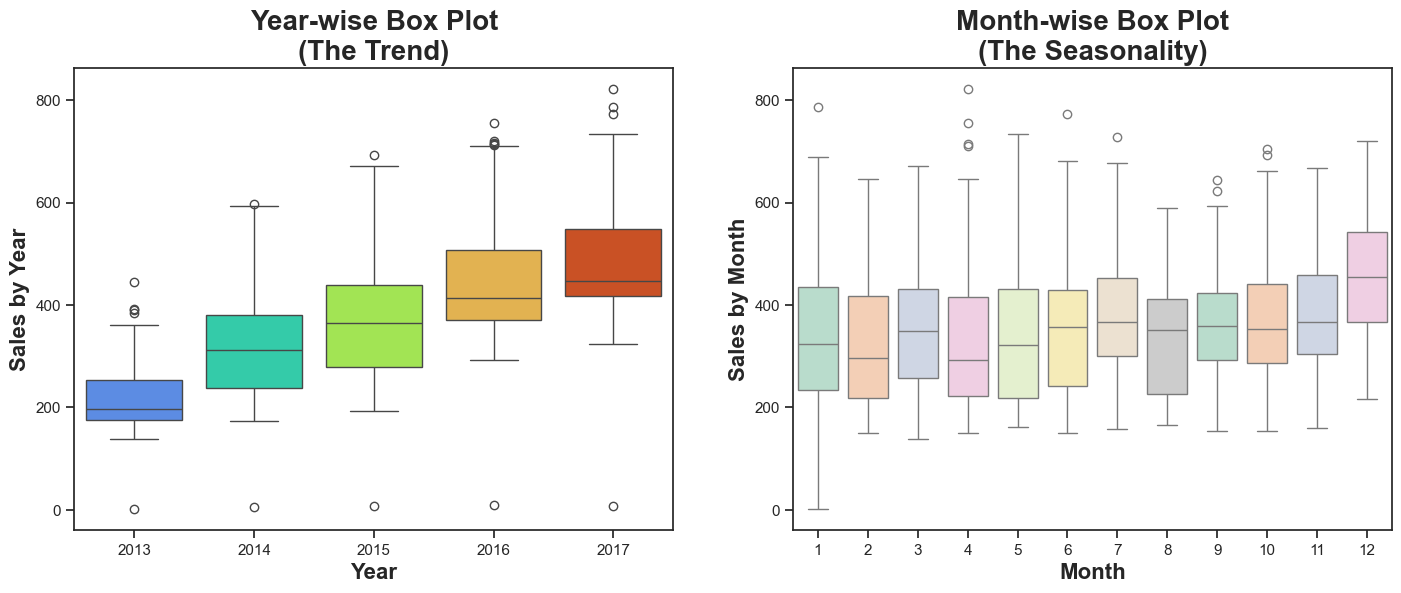

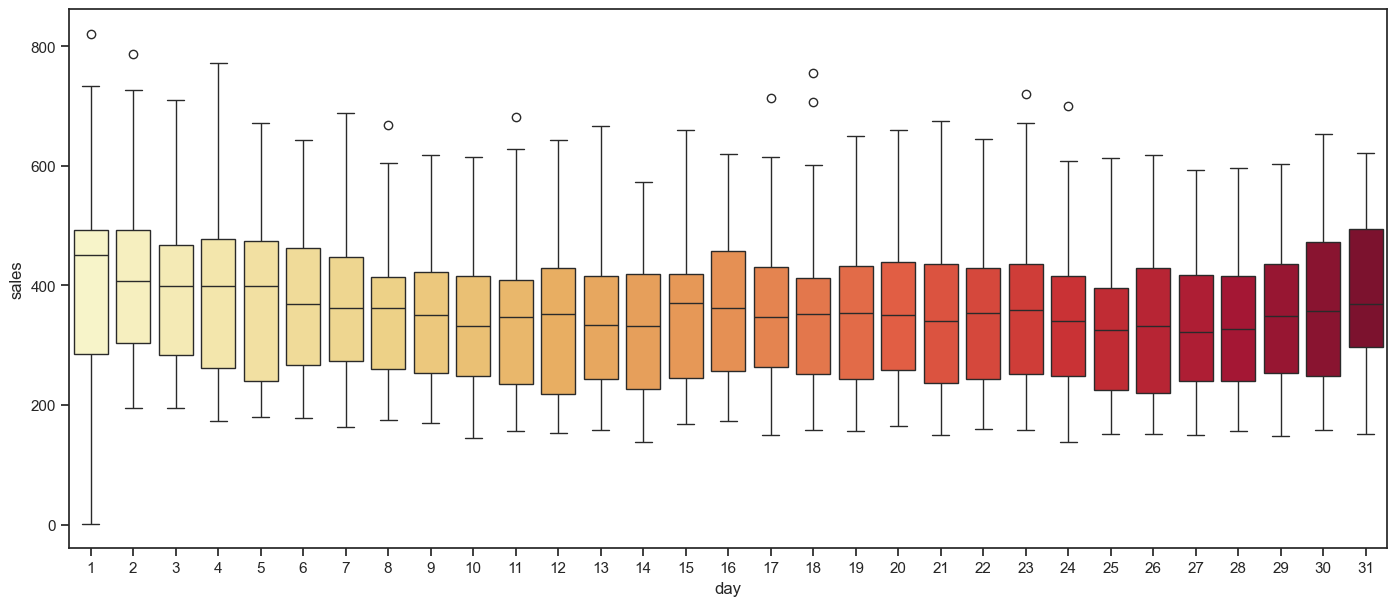

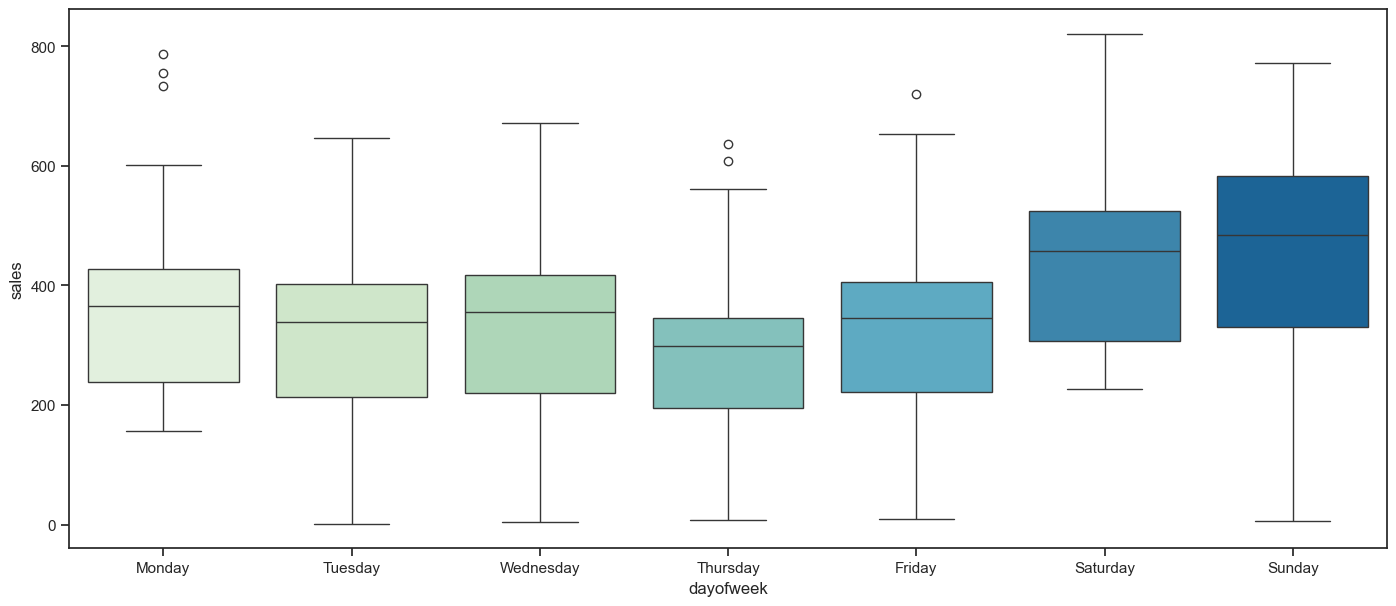

In [34]:
get_seasonality_trend_overview(df_train.drop(columns='family'), 'sales', 'Sales')

## Zeros

In [35]:
df_train_wide = pd.pivot(df_train, index=["date"], columns=["store_nbr","family"], values=["sales"])
df_train_wide.head()

sales                                                \
store_nbr          1                                                  
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

                                                                               \
store_nbr                                                                       
family     CELEBRATION CLEANING  DAIRY     DELI   EGGS FROZEN FOODS GROCERY I   
date                                                                            
2013-01-01         0.0      0.0    0.0    0.000    0.0        0.000       0.0   
2013-01-02         0.0   1060.0  579.0  164.069  246.0      131.000    2652.0   
2013-01-03         0.0    836.0  453.0  151.582  203.0       87.044    2121.0   
2013-01-04         0.0    827.0  460.0  131.411  171.0       65.000    2056.0   
2013-01-05         0.0    811.0  464.0  118.613  177.0       70.000    2216.0   

                                                                       \
store_nbr                                                               
family     GROCERY II HARDWARE HOME AND KITCHEN I HOME AND KITCHEN II   
date                                                                    
2013-01-01        0.0      0.0                0.0                 0.0   
2013-01-02       31.0      3.0                0.0                 0.0   
2013-01-03       12.0      1.0                0.0                 0.0   
2013-01-04       15.0      7.0                0.0                 0.0   
2013-01-05       30.0      1.0                0.0                 0.0   

                                                                          \
store_nbr                                                                  
family     HOME APPLIANCES HOME CARE LADIESWEAR LAWN AND GARDEN LINGERIE   
date                                                                       
2013-01-01             0.0       0.0        0.0             0.0      0.0   
2013-01-02             0.0       0.0        0.0            10.0     13.0   
2013-01-03             2.0       0.0        0.0             0.0     15.0   
2013-01-04             0.0       0.0        0.0             7.0     24.0   
2013-01-05             0.0       0.0        0.0            10.0     20.0   

                                                                           \
store_nbr                                                                   
family     LIQUOR,WINE,BEER MAGAZINES    MEATS PERSONAL CARE PET SUPPLIES   
date                                                                        
2013-01-01              0.0       0.0    0.000           0.0          0.0   
2013-01-02             67.0       0.0  369.101         194.0          0.0   
2013-01-03             66.0       0.0  272.319         153.0          0.0   
2013-01-04            102.0       0.0  454.172          88.0          0.0   
2013-01-05            159.0       0.0  328.940         141.0          0.0   

                                                                      \
store_nbr                                                              
family     PLAYERS AND ELECTRONICS    POULTRY PREPARED FOODS PRODUCE   
date                                                                   
2013-01-01                     0.0    0.00000            0.0     0.0   
2013-01-02                     0.0  247.29700           47.0     0.0   
2013-01-03                     0.0  187.27800           63.0     0.0   
2013-01-04                     0.0  258.02300           67.0     0.0   
2013-01-05                     0.

there are store-family pairs with all target zeros

In [36]:
all_zeros = df_train_wide.loc[:, (df_train_wide == 0).all()]
all_zeros.head()

sales                                                          \
store_nbr         1     10    11    12        13          14                   
family     BABY CARE BOOKS BOOKS BOOKS BABY CARE BOOKS BOOKS LAWN AND GARDEN   
date                                                                           
2013-01-01       0.0   0.0   0.0   0.0       0.0   0.0   0.0             0.0   
2013-01-02       0.0   0.0   0.0   0.0       0.0   0.0   0.0             0.0   
2013-01-03       0.0   0.0   0.0   0.0       0.0   0.0   0.0             0.0   
2013-01-04       0.0   0.0   0.0   0.0       0.0   0.0   0.0             0.0   
2013-01-05       0.0   0.0   0.0   0.0       0.0   0.0   0.0             0.0   

                                                                       \
store_nbr     15    16               17    18    19    20    21    22   
family     BOOKS BOOKS LADIESWEAR BOOKS BOOKS BOOKS BOOKS BOOKS BOOKS   
date                                                                    
2013-01-01   0.0   0.0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-01-02   0.0   0.0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-01-03   0.0   0.0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-01-04   0.0   0.0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-01-05   0.0   0.0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                                                                         \
store_nbr         23         25    28               29               30   
family     BABY CARE LADIESWEAR BOOKS LADIESWEAR BOOKS LADIESWEAR BOOKS   
date                                                                      
2013-01-01       0.0        0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-02       0.0        0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-03       0.0        0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-04       0.0        0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-05       0.0        0.0   0.0        0.0   0.0        0.0   0.0   

                                                                          \
store_nbr                     31    32               33               34   
family     LAWN AND GARDEN BOOKS BOOKS LADIESWEAR BOOKS LADIESWEAR BOOKS   
date                                                                       
2013-01-01             0.0   0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-02             0.0   0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-03             0.0   0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-04             0.0   0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-05             0.0   0.0   0.0        0.0   0.0        0.0   0.0   

                                                                           \
store_nbr     35               36    39    40               43              
family     BOOKS LADIESWEAR BOOKS BOOKS BOOKS LADIESWEAR BOOKS LADIESWEAR   
date                                                                        
2013-01-01   0.0        0.0   0.0   0.0   0.0        0.0   0.0        0.0   
2013-01-02   0.0        0.0   0.0   0.0   0.0        0.0   0.0        0.0   
2013-01-03   0.0        0.0   0.0   0.0   0.0        0.0   0.0        0.0   
2013-01-04   0.0        0.0   0.0   0.0   0.0        0.0   0.0        0.0   
2013-01-05   0.0        0.0   0.0   0.0   0.0        0.0   0.0        0.0   

                                                                        \
store_nbr         44        45        46        47        48        49   
family     BABY CARE BABY CARE BABY CARE BABY CARE BABY CARE BABY CARE   
date                                                                     
2013-01-01       0.0       0.0       0.0       0.0       0.0       0.0   
2013-01-02       0.0       0.0       0.0       0.0       0.0       0.0   
2013-01-03       0.0       0.0       0.0       0.0       0.0       0.0   
2013-01-04       0.0       0.0       0.0       0.0       0.0   

is this more connected with different stores or different family products?

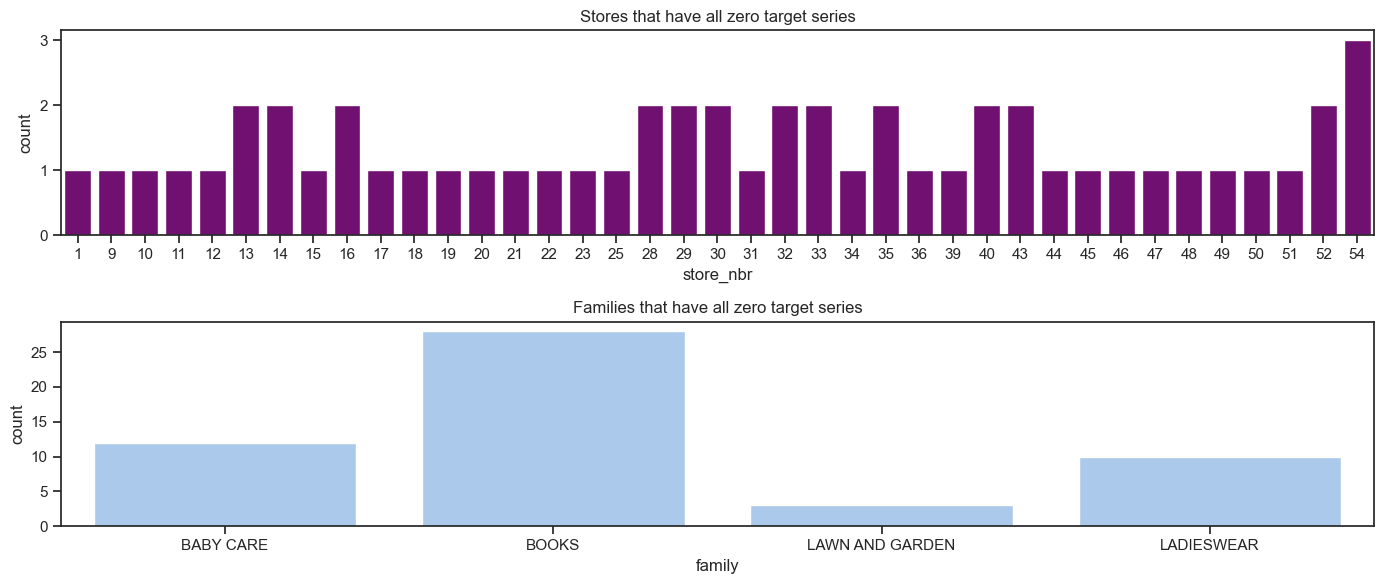

In [37]:
all_zero_pairs = all_zeros.columns.to_frame().reset_index(drop=True).drop(columns=0)
fig = plt.figure(figsize=(14, 6))

ax0=sns.countplot( data=all_zero_pairs, x="store_nbr",color="purple", ax=fig.add_subplot(211))
plt.title("Stores that have all zero target series")

ax0=sns.countplot( data=all_zero_pairs, x="family", ax=fig.add_subplot(212))
plt.title("Families that have all zero target series")

plt.tight_layout()
plt.show()

conclusion: uniformly throughout stores, probably some families of products are not being (successfully) sold in some stores

Problem: leading zeros

In [38]:
def num_leading_zeros(series):
    nz_idx = np.where(series != 0)[0] # bc it returns a tuple
    if len(nz_idx) == 0:
        # all zeros
        return len(series)
    else:
        return nz_idx[0]
    
# for all pairs store-family number of leading zeros
leading_zeros = df_train_wide.apply(num_leading_zeros).to_frame("num_leading_zeros").reset_index()
# removing all zeros series
leading_zeros = leading_zeros[leading_zeros["num_leading_zeros"] != df_train_wide.shape[0]]

In [39]:
leading_zeros.head()

level_0  store_nbr        family  num_leading_zeros
0   sales          1    AUTOMOTIVE                  1
2   sales          1        BEAUTY                  1
3   sales          1     BEVERAGES                  1
4   sales          1         BOOKS               1378
5   sales          1  BREAD/BAKERY                  1

Is this more store or family related?

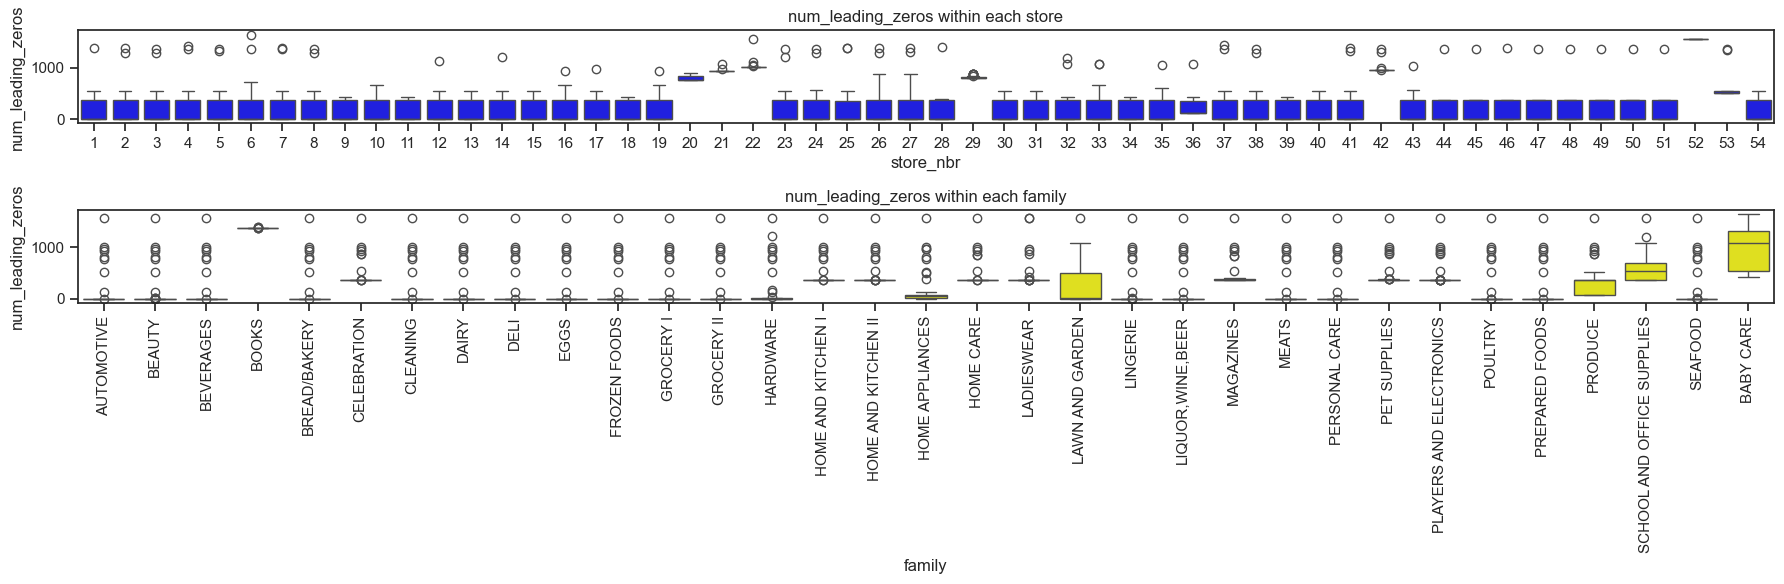

In [40]:
plot_zeros(leading_zeros, "num_leading_zeros")

conclusion: same conclusion as all zeros conclusion 

Problem: trailing zeros

In [41]:
def num_trailing_zeros(series):
    nz_idx = np.where(series != 0)[0] # bc it returns a tuple
    if len(nz_idx) == 0:
        # all zeros
        return len(series)
    else:
        return len(series) - nz_idx[-1] - 1
    
# for all pairs store-family number of trailing zeros
trailing_zeros = df_train_wide.apply(num_trailing_zeros).to_frame("num_trailing_zeros").reset_index()
# removing all zeros series
trailing_zeros = trailing_zeros[trailing_zeros["num_trailing_zeros"] != df_train_wide.shape[0]]

In [42]:
trailing_zeros.head()

level_0  store_nbr        family  num_trailing_zeros
0   sales          1    AUTOMOTIVE                   0
2   sales          1        BEAUTY                   0
3   sales          1     BEVERAGES                   0
4   sales          1         BOOKS                  15
5   sales          1  BREAD/BAKERY                   0

Is this more store or family related?

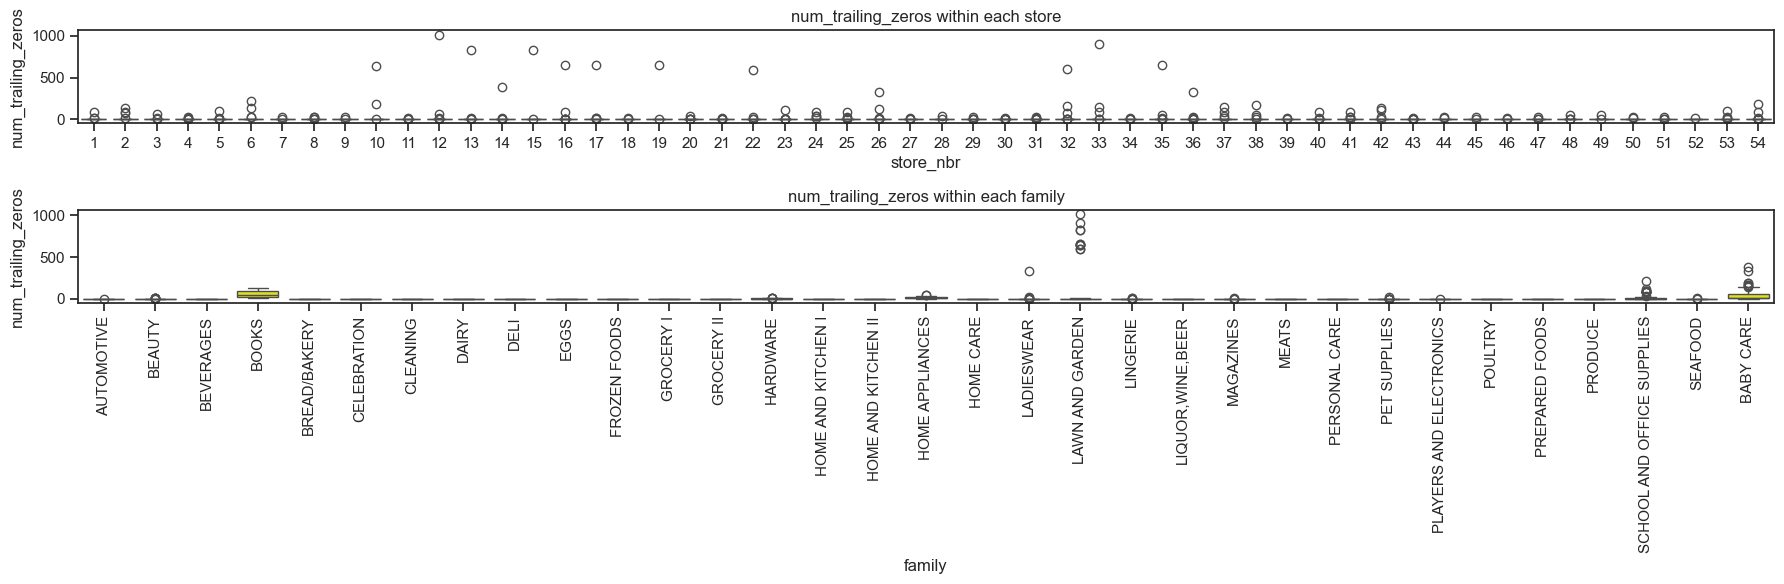

In [43]:
plot_zeros(trailing_zeros, "num_trailing_zeros")

conclusion: "poor sales performance or that the product is no longer available towards the end. An example would be lawn and garden. In this case, generating zero forecasts for such target series would be a reasonable approach."

## Correlations

In [44]:
scaler=MinMaxScaler()

train_wide_scaled = df_train_wide.copy()
for col in train_wide_scaled.columns:
    train_wide_scaled[col] = scaler.fit_transform(train_wide_scaled[[col]])

train_wide_scaled.head()

sales                                                   \
store_nbr          1                                                     
family     AUTOMOTIVE BABY CARE    BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                     
2013-01-01   0.000000       0.0  0.000000  0.000000   0.0     0.000000   
2013-01-02   0.105263       0.0  0.166667  0.215997   0.0     0.631313   
2013-01-03   0.157895       0.0  0.000000  0.181944   0.0     0.416700   
2013-01-04   0.157895       0.0  0.250000  0.188676   0.0     0.266080   
2013-01-05   0.263158       0.0  0.250000  0.229657   0.0     0.403825   

                                                                             \
store_nbr                                                                     
family     CELEBRATION  CLEANING     DAIRY      DELI      EGGS FROZEN FOODS   
date                                                                          
2013-01-01         0.0  0.000000  0.000000  0.000000  0.000000     0.000000   
2013-01-02         0.0  0.638939  0.472653  0.608908  1.000000     0.023356   
2013-01-03         0.0  0.503918  0.369796  0.562565  0.825203     0.015519   
2013-01-04         0.0  0.498493  0.375510  0.487704  0.695122     0.011589   
2013-01-05         0.0  0.488849  0.378776  0.440207  0.719512     0.012481   

                                                              \
store_nbr                                                      
family     GROCERY I GROCERY II  HARDWARE HOME AND KITCHEN I   
date                                                           
2013-01-01  0.000000   0.000000  0.000000                0.0   
2013-01-02  0.292554   0.206667  0.230769                0.0   
2013-01-03  0.233977   0.080000  0.076923                0.0   
2013-01-04  0.226806   0.100000  0.538462                0.0   
2013-01-05  0.244457   0.200000  0.076923                0.0   

                                                                     \
store_nbr                                                             
family     HOME AND KITCHEN II HOME APPLIANCES HOME CARE LADIESWEAR   
date                                                                  
2013-01-01                 0.0        0.000000       0.0        0.0   
2013-01-02                 0.0        0.000000       0.0        0.0   
2013-01-03                 0.0        0.333333       0.0        0.0   
2013-01-04                 0.0        0.000000       0.0        0.0   
2013-01-05                 0.0        0.000000       0.0        0.0   

                                                                           \
store_nbr                                                                   
family     LAWN AND GARDEN  LINGERIE LIQUOR,WINE,BEER MAGAZINES     MEATS   
date                                                                        
2013-01-01        0.000000  0.000000         0.000000       0.0  0.000000   
2013-01-02        0.095238  0.276596         0.112605       0.0  0.329662   
2013-01-03        0.000000  0.319149         0.110924       0.0  0.243221   
2013-01-04        0.066667  0.510638         0.171429       0.0  0.405643   
2013-01-05        0.095238  0.425532         0.267227       0.0  0.293792   

                                                                         \
store_nbr                                                                 
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   POULTRY   
date                                                                      
2013-01-01      0.000000          0.0                     0.0  0.000000   
2013-01-02      0.243108          0.0                     0.0  0.277302   
2013-01-03      0.191729          0.0                     0.0  0.210000   
2013-01-04      0.110276          0.0                     0.0  0.289329   
2013-01-05      0.176692          0.0                     0.0  0.238095   

                                                  

In [45]:
# convert back to long form
df_sales_scaled = train_wide_scaled.melt(value_name='sales_scaled', ignore_index=False).reset_index()
df_sales_scaled_sorted = df_sales_scaled.sort_values(by=['date', 'store_nbr','family'])
df_sales_scaled_sorted = df_sales_scaled_sorted.reset_index(drop=True)
df_sales_scaled_sorted.tail()

date   None  store_nbr                      family  sales_scaled
3000883 2017-08-15  sales         54                     POULTRY      0.168551
3000884 2017-08-15  sales         54              PREPARED FOODS      0.525140
3000885 2017-08-15  sales         54                     PRODUCE      0.540480
3000886 2017-08-15  sales         54  SCHOOL AND OFFICE SUPPLIES      0.000000
3000887 2017-08-15  sales         54                     SEAFOOD      0.125000

### Onpromotion

In [46]:
train_prom = df_train.copy()

#wide format
train_prom_wide = pd.pivot(train_prom, index='date', columns=['store_nbr','family'], values='onpromotion')

#scaling promotion for
train_prom_wide_scaled = train_prom_wide.copy()
for col in train_prom_wide_scaled.columns:
    train_prom_wide_scaled[col] = scaler.fit_transform(train_prom_wide_scaled[[col]])

train_prom_wide_scaled.sample()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2014-02-22        0.0       0.0    0.0       0.0   0.0          0.0   

store_nbr                                                               \
family     CELEBRATION CLEANING DAIRY DELI EGGS FROZEN FOODS GROCERY I   
date                                                                     
2014-02-22         0.0      0.0   0.0  0.0  0.0          0.0       0.0   

store_nbr                                                              \
family     GROCERY II HARDWARE HOME AND KITCHEN I HOME AND KITCHEN II   
date                                                                    
2014-02-22        0.0      0.0                0.0                 0.0   

store_nbr                                                                 \
family     HOME APPLIANCES HOME CARE LADIESWEAR LAWN AND GARDEN LINGERIE   
date                                                                       
2014-02-22             0.0       0.0        0.0             0.0      0.0   

store_nbr                                                               \
family     LIQUOR,WINE,BEER MAGAZINES MEATS PERSONAL CARE PET SUPPLIES   
date                                                                     
2014-02-22              0.0       0.0   0.0           0.0          0.0   

store_nbr                                                          \
family     PLAYERS AND ELECTRONICS POULTRY PREPARED FOODS PRODUCE   
date                                                                
2014-02-22                     0.0     0.0            0.0     0.0   

store_nbr                                             10                   \
family     SCHOOL AND OFFICE SUPPLIES SEAFOOD AUTOMOTIVE BABY CARE BEAUTY   
date                                                                        
2014-02-22                        0.0     0.0        0.0       0.0    0.0   

store_nbr                                                                     \
family     BEVERAGES BOOKS BREAD/BAKERY CELEBRATION CLEANING DAIRY DELI EGGS   
date                                                                           
2014-02-22       0.0   0.0          0.0         0.0      0.0   0.0  0.0  0.0   

store_nbr                                                                 \
family     FROZEN FOODS GROCERY I GROCERY II HARDWARE HOME AND KITCHEN I   
date                                                                       
2014-02-22          0.0       0.0        0.0      0.0                0.0   

store_nbr                                                            \
family     HOME AND KITCHEN II HOME APPLIANCES HOME CARE LADIESWEAR   
date                                                                  
2014-02-22                 0.0             0.0       0.0        0.0   

store_nbr                                                             \
family     LAWN AND GARDEN LINGERIE LIQUOR,WINE,BEER MAGAZINES MEATS   
date                                                                   
2014-02-22             0.0      0.0              0.0       0.0   0.0   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2014-02-22           0.0          0.0                     0.0     0.0   

store_nbr                                                             \
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD   
date                                                                   
2014-02-22            0.0     0.0                        0.0     0.0   

store_nbr          11                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date         

Correlation between prom_scaled and sales_scaled: 0.30114940024437264


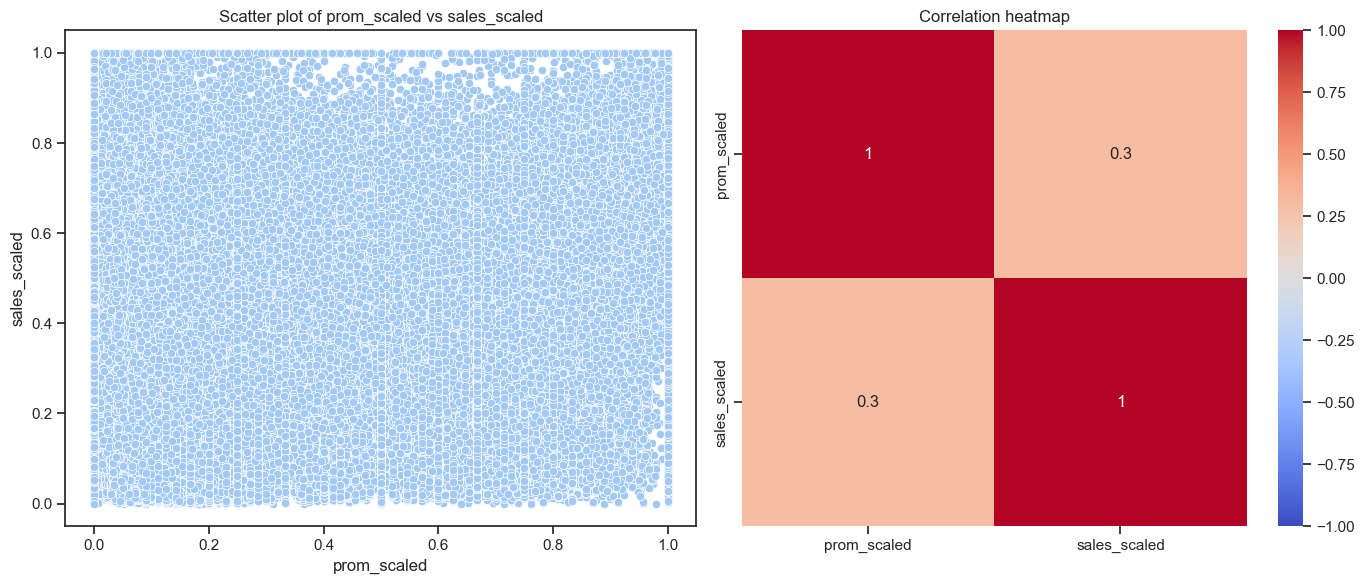

In [47]:
# convert back to long form

df_prom_scaled = train_prom_wide_scaled.melt(value_name='prom_scaled', ignore_index=False).reset_index()
df_prom_scaled_sorted = df_prom_scaled.sort_values(by=['date', 'store_nbr' ,'family'])
df_prom_scaled_sorted = df_prom_scaled_sorted.reset_index(drop=True)

# adding sales_scaled column to train_prom
train_prom.loc[:,'sales_scaled'] = df_sales_scaled_sorted.loc[:,'sales_scaled'].copy()
train_prom.loc[:,'prom_scaled'] = df_prom_scaled_sorted.loc[:,'prom_scaled'].copy()

plot_correlation(train_prom['prom_scaled'], train_prom['sales_scaled'])

checking promotion correlation with different families

In [48]:
family_promo_corr = pd.Series(
    {fam: train_prom[train_prom['family'] == fam]['prom_scaled'].corr(train_prom[train_prom['family'] == fam]['sales_scaled'])
     for fam in df_train['family'].unique()}
)

family_promo_corr.sort_values(ascending=False)
# BOOKS are never on promotion

SCHOOL AND OFFICE SUPPLIES    0.588960
PRODUCE                       0.448216
BEVERAGES                     0.442064
HOME CARE                     0.411711
BEAUTY                        0.328253
DAIRY                         0.304040
MEATS                         0.295704
HOME AND KITCHEN I            0.294272
SEAFOOD                       0.269534
GROCERY I                     0.260793
PET SUPPLIES                  0.246390
BREAD/BAKERY                  0.245726
HOME AND KITCHEN II           0.234865
LAWN AND GARDEN               0.232771
FROZEN FOODS                  0.218614
PERSONAL CARE                 0.206704
POULTRY                       0.199801
LIQUOR,WINE,BEER              0.198268
DELI                          0.180141
CLEANING                      0.135449
AUTOMOTIVE                    0.127871
PREPARED FOODS                0.127793
EGGS                          0.120620
CELEBRATION                   0.116698
GROCERY II                    0.090691
PLAYERS AND ELECTRONICS  

In [49]:
# mean sales and mean promotion
mean_train_wide_scaled = train_wide_scaled.mean(axis=1).to_frame("sales").reset_index()
mean_train_prom_wide_scaled = train_prom_wide_scaled.mean(axis=1).to_frame("onpromotion").reset_index()

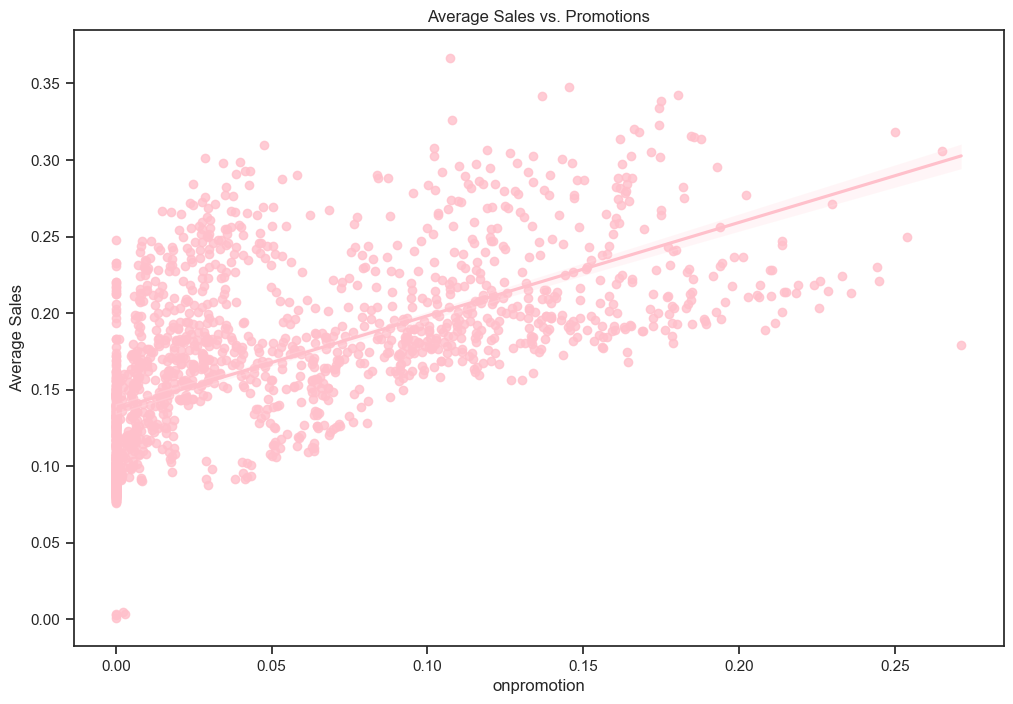

In [50]:
# plot mean sales mean promotion
# every point is one date
fig = plt.figure(figsize=(12, 8))
sns.regplot(x=mean_train_prom_wide_scaled.onpromotion, y=mean_train_wide_scaled.sales, color='pink')
plt.xlabel("onpromotion")
plt.ylabel("Average Sales")
plt.title("Average Sales vs. Promotions")

plt.show()

conclusion: promotions are positively corr with avg sales

### Transactions - same process as promotions

In [60]:
########### loading future csv for ploting ###########
df = pd.read_csv("originalni_datasetovi/train_test_v1.csv", parse_dates=['date'])
train = df[df['date'] < '2017-08-16']

train_wide=pd.pivot(train, index=['date'], columns=['store_nbr','family'], values=['sales'])
train_wide_scaled=train_wide.copy()
for col in train_wide_scaled.columns:
    train_wide_scaled[col] = scaler.fit_transform(train_wide_scaled[[col]])


train_trans = train.copy()
# wide format
train_trans_wide = pd.pivot(train_trans, index='date', columns=['store_nbr','family'], values='transactions')

# scaling transactions for plotting
train_trans_wide_scaled = train_trans_wide.copy()
for col in train_trans_wide_scaled.columns:
    train_trans_wide_scaled[col] = scaler.fit_transform(train_trans_wide_scaled[[col]])

train_trans_wide_scaled.head()

store_nbr          1                                                        \
family     AUTOMOTIVE BABY CARE    BEAUTY BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                         
2013-01-01   0.000000  0.000000  0.000000  0.000000  0.000000     0.000000   
2013-01-02   0.698313  0.698313  0.698313  0.698313  0.698313     0.698313   
2013-01-03   0.606351  0.606351  0.606351  0.606351  0.606351     0.606351   
2013-01-04   0.616275  0.616275  0.616275  0.616275  0.616275     0.616275   
2013-01-05   0.499173  0.499173  0.499173  0.499173  0.499173     0.499173   

store_nbr                                                                    \
family     CELEBRATION  CLEANING     DAIRY      DELI      EGGS FROZEN FOODS   
date                                                                          
2013-01-01    0.000000  0.000000  0.000000  0.000000  0.000000     0.000000   
2013-01-02    0.698313  0.698313  0.698313  0.698313  0.698313     0.698313   
2013-01-03    0.606351  0.606351  0.606351  0.606351  0.606351     0.606351   
2013-01-04    0.616275  0.616275  0.616275  0.616275  0.616275     0.616275   
2013-01-05    0.499173  0.499173  0.499173  0.499173  0.499173     0.499173   

store_nbr                                                     \
family     GROCERY I GROCERY II  HARDWARE HOME AND KITCHEN I   
date                                                           
2013-01-01  0.000000   0.000000  0.000000           0.000000   
2013-01-02  0.698313   0.698313  0.698313           0.698313   
2013-01-03  0.606351   0.606351  0.606351           0.606351   
2013-01-04  0.616275   0.616275  0.616275           0.616275   
2013-01-05  0.499173   0.499173  0.499173           0.499173   

store_nbr                                                            \
family     HOME AND KITCHEN II HOME APPLIANCES HOME CARE LADIESWEAR   
date                                                                  
2013-01-01            0.000000        0.000000  0.000000   0.000000   
2013-01-02            0.698313        0.698313  0.698313   0.698313   
2013-01-03            0.606351        0.606351  0.606351   0.606351   
2013-01-04            0.616275        0.616275  0.616275   0.616275   
2013-01-05            0.499173        0.499173  0.499173   0.499173   

store_nbr                                                                  \
family     LAWN AND GARDEN  LINGERIE LIQUOR,WINE,BEER MAGAZINES     MEATS   
date                                                                        
2013-01-01        0.000000  0.000000         0.000000  0.000000  0.000000   
2013-01-02        0.698313  0.698313         0.698313  0.698313  0.698313   
2013-01-03        0.606351  0.606351         0.606351  0.606351  0.606351   
2013-01-04        0.616275  0.616275         0.616275  0.616275  0.616275   
2013-01-05        0.499173  0.499173         0.499173  0.499173  0.499173   

store_nbr                                                                \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   POULTRY   
date                                                                      
2013-01-01      0.000000     0.000000                0.000000  0.000000   
2013-01-02      0.698313     0.698313                0.698313  0.698313   
2013-01-03      0.606351     0.606351                0.606351  0.606351   
2013-01-04      0.616275     0.616275                0.616275  0.616275   
2013-01-05      0.499173     0.499173                0.499173  0.499173   

store_nbr                                                                 \
family     PREPARED FOODS   PRODUCE SCHOOL AND OFFICE SUPPLIES   SEAFOOD   
date                                                                       
2013-01-01       0.000000  0.000000                   0.000000  0.000000   
2013-01-02       0.698313  0.698313                   0.698313  0.698313   
2013-01-03       0.606351  0.606351                   0.606351

Correlation between trans_scaled and sales_scaled: 0.2366704321651558


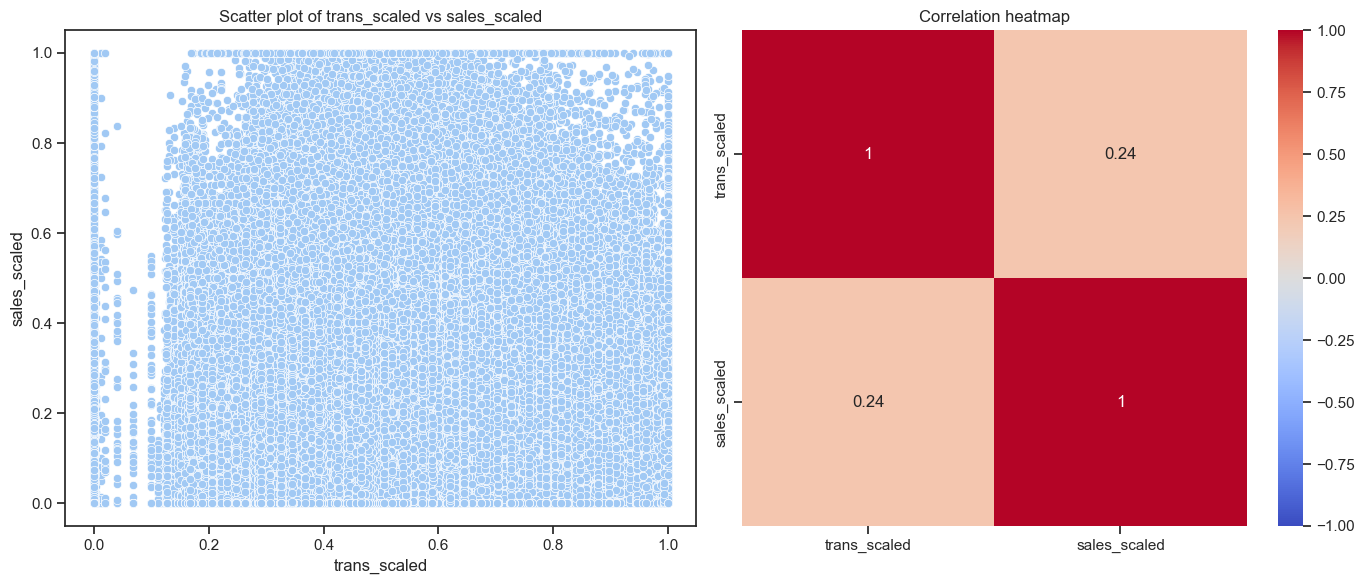

In [61]:
# convert back to long form
df_trans_scaled=train_trans_wide_scaled.melt(value_name='trans_scaled', ignore_index=False).reset_index()
df_trans_scaled_sorted = df_trans_scaled.sort_values(by=['date', 'store_nbr','family'])
df_trans_scaled_sorted=df_trans_scaled_sorted.reset_index(drop=True)
df_trans_scaled_sorted.head()

# adding sales_scaled column to train_prom
train_trans.loc[:,'sales_scaled'] = df_sales_scaled_sorted.loc[:,'sales_scaled'].copy()
train_trans.loc[:,'trans_scaled'] = df_trans_scaled_sorted.loc[:,'trans_scaled'].copy()

plot_correlation(train_trans['trans_scaled'], train_trans['sales_scaled'])

checking transaction correlation with different families

In [62]:
family_trans_corr = pd.Series(
    {fam: train_trans[train_trans['family'] == fam]['trans_scaled'].corr(train_trans[train_trans['family'] == fam]['sales_scaled'])
     for fam in train['family'].unique()}
)

family_trans_corr.sort_values(ascending=False)

DELI                          0.572052
DAIRY                         0.513597
PREPARED FOODS                0.499089
BREAD/BAKERY                  0.498908
MEATS                         0.445438
GROCERY I                     0.440250
CLEANING                      0.425952
PERSONAL CARE                 0.413872
EGGS                          0.412965
BEVERAGES                     0.393142
POULTRY                       0.393055
SEAFOOD                       0.315575
GROCERY II                    0.311141
LINGERIE                      0.280449
FROZEN FOODS                  0.264282
AUTOMOTIVE                    0.252618
LIQUOR,WINE,BEER              0.250116
PRODUCE                       0.249998
BEAUTY                        0.233816
HOME CARE                     0.213825
HARDWARE                      0.198000
PLAYERS AND ELECTRONICS       0.183215
LADIESWEAR                    0.170806
HOME AND KITCHEN II           0.167236
HOME AND KITCHEN I            0.155293
HOME APPLIANCES          

In [58]:
#mean sales and mean transactions
#mean_train_wide_scaled = train_wide_scaled.mean(axis=1).to_frame("sales").reset_index()
mean_train_trans_wide_scaled = train_trans_wide_scaled.mean(axis=1).to_frame("transactions").reset_index()

#plot mean sales and oil prices
#every point is one date
fig = plt.figure(figsize=(12, 8))
sns.regplot(x=mean_train_trans_wide_scaled.transactions, y=mean_train_wide_scaled.sales, color='blue')
plt.xlabel("transactions")
plt.ylabel("Average Sales")
plt.title("Average Sales vs. Transactions")

plt.show()


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1688 and the array at index 1 has size 1684

<Figure size 1200x800 with 0 Axes>

conclusion: transactions are positively corr with avg sales

### Work Day

In [ ]:
train_c = df_train.copy()
train_c.loc[:,'sales_scaled']=df_sales_scaled_sorted.loc[:,'sales_scaled'].copy()

plot_boxplots(data=train_c[(train_c.date.dt.weekday==5)], y="work_day")